# **Q1K** Validation of EEG-ET Log

In [429]:
# Import modules
import os
import pandas as pd
from pathlib import Path
import numpy as np
import glob
import shutil
from matplotlib import pyplot as plt
import plotly.express as px
import plotly.graph_objects as go
import plotly.offline as py
import plotly.io as pio
import seaborn as sns
import kaleido


### Functions

In [430]:
def map_values(series, col_name):
    """Map numeric values to their labels if a mapping exists"""
    if col_name in category_mappings:
        return series.map(category_mappings[col_name]).fillna(series)
    return series

def get_top_categories(series, col_name, percent=False):
    """Get top categories with proper value mapping"""
    mapped_series = map_values(series, col_name)

    if percent:
        value_counts = mapped_series.value_counts(normalize=True, dropna=False)
        value_counts = value_counts.round(2)
    else:
        value_counts = mapped_series.value_counts(dropna=False)
    return {k: v for k, v in value_counts.head(5).items() if not pd.isna(k)}

# 1. Extracting REDCap EEG LOG

In [431]:
# Select the date
date="2025_05_06"

In [432]:
# Select the tasks
tasks = ['RS','TO','GO', 'VEP', 'AEP', 'NSP', 'PLR','VS','MMN']

In [433]:
for file in glob.glob(f"../source/{date}/*"):
    if "Validation" in file:
        vali_df = pd.read_csv(file)
        print( "Validation file is: " , file)
    if "LABELS" in file:
        labels_df = pd.read_csv(file)
        print( "Labels file is: " , file)

 

Labels file is:  ../source/2025_05_06\DATA_LABELS_2025-05-06_1717.csv
Validation file is:  ../source/2025_05_06\Q1KDatabase-EEGLogValidation_DATA_2025-05-06_1716.csv


In [434]:
labels_df

,Record ID,Event Name,Was EEG attempted?,Reasons:,EEG site:,Participant EEG code,Eye tracking code,Birthdate,EEG date 1,Age in years REMOVE,...,Notes: .22,Good.24,Questionable.23,Invalid.24,Reasons.23,Notes: .23,End of recording,General session notes:,status change?,Complete?
0,21,Phase 3 (Arm 1: Phase 2),NaN,NaN,NaN,NaN,NaN,1980-05-01,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Incomplete
1,40,Phase 3 (Arm 1: Phase 2),No,NaN,HSJ,Q1K_HSJ_10040_P,NaN,2018-03-17,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Incomplete
2,41,Phase 3 (Arm 1: Phase 2),No,NaN,HSJ,Q1K_HSJ_10040_M1,NaN,1985-01-10,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Incomplete
3,42,Phase 3 (Arm 1: Phase 2),Yes,NaN,MHC,Q1K_MHC_20042_P,Q042_P,1993-08-19,2024-08-09,30.973942,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Complete
4,43,Phase 3 (Arm 1: Phase 2),Yes,NaN,HSJ,Q1K_HSJ_10043_P,NaN,2007-05-02,2024-03-28,16.906576,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Incomplete
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
528,525-1290,Phase 3 (Arm 1: Phase 2),NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Incomplete
529,525-1291,Phase 3 (Arm 1: Phase 2),NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Incomplete
530,525-1292,Phase 3 (Arm 1: Phase 2),NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Incomplete
531,Q1K test - (for Irini),Phase 3 (Arm 1: Phase 2),NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Complete


In [435]:
# Import the label mapping file
mapping_df = pd.read_csv(f"../source/{date}/label_mapping.csv")
mapping_df

,raw_var_name,new_label
0,record_id,Record ID
1,redcap_event_name,Event Name
2,eeg_attempted,Was EEG attempted?
3,eeg_attempted_reasons,Reasons:
4,eeg_site,EEG site:
...,...,...
272,eeget_p8_b2_notes_v2_v2,Notes: .23
273,eeg_endrecord,End of recording
274,eeget_general_notes_v2_v2,General session notes:
275,change_status,status change?


### Subset only participants who completed EEG form

In [436]:
vali_df= vali_df.loc[vali_df['eeg_participant_code'].isna() == False]

In [437]:
vali_df

,record_id,redcap_event_name,eeg_attempted,eeg_attempted_reasons,eeg_site,eeg_participant_code,eeg_code_software,eeg_birthdate_v2_v2,eeg_today_date,eeg_age_years_testdate,...,eeget_p8_b1_notes_v2_v2,eeget_p8_b2_good_v2_v2,eeget_p8_b2_quest_v2_v2,eeget_p8_b2_inv_v2_v2,eeget_p8_b2_reasons_v2_v2,eeget_p8_b2_notes_v2_v2,eeg_endrecord,eeget_general_notes_v2_v2,change_status,eeget_session_log_complete
1,40,phase_3_arm_1,0.0,NaN,1.0,Q1K_HSJ_10040_P,NaN,2018-03-17,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
2,41,phase_3_arm_1,0.0,NaN,1.0,Q1K_HSJ_10040_M1,NaN,1985-01-10,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
3,42,phase_3_arm_1,1.0,NaN,2.0,Q1K_MHC_20042_P,Q042_P,1993-08-19,2024-08-09,30.973942,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2
4,43,phase_3_arm_1,1.0,NaN,1.0,Q1K_HSJ_10043_P,NaN,2007-05-02,2024-03-28,16.906576,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
6,45,phase_3_arm_1,1.0,NaN,1.0,Q1K_HSJ_10043_F1,Q043_F1,1966-04-13,2024-05-31,58.133865,...,NaN,NaN,NaN,NaN,NaN,NaN,14:21,NaN,NaN,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
502,525-1256,phase_3_arm_1,1.0,NaN,1.0,Q1K_HSJ_1525-1256_P,Q1256_P,2009-10-28,2025-05-01,15.507505,...,NaN,NaN,NaN,NaN,NaN,NaN,13:53,NaN,NaN,2
503,525-1257,phase_3_arm_1,1.0,NaN,1.0,Q1K_HSJ_1525-1256_S1,Q1256_S1,2008-01-01,2025-05-01,17.330837,...,NaN,NaN,NaN,NaN,NaN,NaN,12:05,NaN,NaN,2
504,525-1258,phase_3_arm_1,1.0,NaN,1.0,Q1K_HSJ_1525-1256_S2,Q1256_S2,2007-01-03,2025-05-01,18.324698,...,NaN,NaN,NaN,NaN,NaN,NaN,11:00,NaN,NaN,2
505,525-1259,phase_3_arm_1,0.0,No time left. Family had to leave.,1.0,Q1K_HSJ_1525-1256_M1,Q1256_M1,1980-01-06,2025-05-01,45.317723,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2


In [438]:
# List of all columns to validate
vars=vali_df.columns.tolist()

vars

['record_id',
 'redcap_event_name',
 'eeg_attempted',
 'eeg_attempted_reasons',
 'eeg_site',
 'eeg_participant_code',
 'eeg_code_software',
 'eeg_birthdate_v2_v2',
 'eeg_today_date',
 'eeg_age_years_testdate',
 'eeg_age_years',
 'eeg_sex_birth',
 'eeg_sex_birth_specify',
 'eeg_diagnosis',
 'eeg_diagnosis_unk',
 'eeg_diagnosis_other',
 'eeg_participant_medic',
 'eeg_participant_handedness',
 'eeg_age_v2_v2',
 'eeget_date_v2_v2',
 'eeg_time_v2_v2',
 'eeg_exp_v2_v2',
 'eeg_bathroom',
 'eeg_cellphone',
 'egg_light_off',
 'eeg_instal_obs',
 'eeg_head_circ_v2_v2',
 'eeg_height_v2',
 'eeg_nasion_inion_v2_v2',
 'eeg_lefttoright_v2_v2',
 'eeg_44_47',
 'eeg_47_51',
 'eeg_51_54',
 'eeg_54_56',
 'eeg_56_58',
 'eeg_58_61',
 'eeg_other_net_size',
 'eeg_h12664',
 'eeg_s003466',
 'eeg_s004367',
 'eeg_s002720',
 'eeg_s004597',
 'eeg_s004463',
 'eeg_h12417',
 'eeg_h12416',
 'eeg_h12419',
 'eeg_h12424',
 'eeg_h12432',
 'eeg_h12421',
 'eeget_hc_netsize_v2_v2',
 'eeg_size_other_v2_v2',
 'eeg_fit_v2_v2',
 '

In [439]:
# Principal columns

principal_cols = ['record_id','eeg_attempted',
 'eeg_attempted_reasons',
 'eeg_site',
 'eeg_participant_code',
 'eeg_code_software',
 'eeg_birthdate_v2_v2',
 'eeg_today_date',
 'eeg_age_years_testdate',
 'eeg_age_years',
 'eeg_sex_birth',
 'eeg_participant_medic',
 'eeg_participant_handedness',
 'eeg_age_v2_v2',
 'eeget_date_v2_v2']

In [440]:
# Select the columns that are needed
main_vali= vali_df[principal_cols]

## Validation of main vairables (e..g, Age, Sex, etc)

In [441]:
main_vali.columns

Index(['record_id', 'eeg_attempted', 'eeg_attempted_reasons', 'eeg_site',
       'eeg_participant_code', 'eeg_code_software', 'eeg_birthdate_v2_v2',
       'eeg_today_date', 'eeg_age_years_testdate', 'eeg_age_years',
       'eeg_sex_birth', 'eeg_participant_medic', 'eeg_participant_handedness',
       'eeg_age_v2_v2', 'eeget_date_v2_v2'],
      dtype='object')

In [442]:
# Column type mappings
column_types = {
            'yes_no': ['eeg_attempted', 'eeg_diagnosis___1', 'eeg_diagnosis___2', 
                            'eeg_diagnosis___3', 'eeg_diagnosis___4', 'eeg_diagnosis___5', 
                            'eeg_diagnosis_unk'],
            'categorical': ['eeg_sex_birth', 'eeg_site', 'eeg_participant_handedness'],
            'numerical': ['eeg_age_years', 'eeg_age_years_testdate', 'eeg_age_v2_v2'],
            'date': ['eeg_birthdate_v2_v2', 'eeg_today_date', 'eeget_date_v2_v2'],
            'text': ['eeg_participant_code', 'eeg_code_software', 'eeg_sex_birth_specify', 
                    'eeg_diagnosis_unk', 'eeg_participant_medic', 'eeg_attempted_reasons',"record_id"]
        }




In [443]:
category_mappings = {
    'eeg_attempted': {1.0: 'Yes', 0.0: 'No'},
    'eeg_sex_birth': {1: 'Female', 2: 'Male', 3: 'Other'},
    'eeg_participant_handedness': {1: 'Right', 2: 'Left', 3: 'Ambidextrous'},
    'eeg_site': {1: 'HSJ', 2: 'MHC'},
    'eeg_fit_v2_v2': {1.0: 'Good', 2.0: "Okay", 3.0: 'Poor'},
    'eeg_imped_v2_v2': {1.0: 'Good', 2.0: 'Okay', 3.0: 'Poor'},
    'eeg_vep_a_b_file': {0.0: "A", 1.0: "B"},
     'eeg_ssaep_a_b_version': {1.0: "A", 0.0: "B"},
     'eeg_mmn_a_b_file': {1.0: "A", 0.0: "B"},
     'eeg_p2_rand_v2_v2': {1.0: "A", 0.0: "B"}
 }

# Special columns
special_cols = ['eeg_sex_birth_specify', 'eeg_diagnosis_unk', 'eeg_participant_medic', 'eeg_diagnosis_other']

In [444]:
validation_results = []

# Create table for validation results

#Forms to check 
inds_val_required= []
participant_list=  set()

# Check columns

symmary_df=main_vali.copy()
for col in symmary_df.columns: 
    # Process each column
    col_type = next((t for t, cols in column_types.items() if col in cols), 'unknown')

 
    if col in ['eeg_attempted', 'eeg_today_date', 'eeget_date_v2_v2']:
        df = symmary_df
        print("All columns checked for column:", col)
        inds_val_required.append({'Column': col, 'Participants': df.loc[df[col].isna(), 'eeg_participant_code'].unique().tolist()})
        missing_ids = df.loc[df[col].isna(), 'record_id'].unique()
        participant_list.update(missing_ids)
 
    elif col == 'eeg_attempted_reasons':
        # Check those 
        df = symmary_df[symmary_df['eeg_attempted'] == 0.0]
        print("All columns checked for column:", col)
        inds_val_required.append({'Column': col, 'Participants': df.loc[df[col].isna(), 'eeg_participant_code'].unique().tolist()})
        missing_ids = df.loc[df[col].isna(), 'record_id'].unique()
        participant_list.update(missing_ids)
    
    elif col in special_cols:
        if col == 'eeg_sex_birth_specify':
            # Check those that are not in the list
            df = symmary_df[symmary_df['eeg_sex_birth'].isna()]
        elif col == 'eeg_diagnosis_unk':
            # Check those that are not in the list
            df = symmary_df[symmary_df['eeg_diagnosis_unk'].isna()]

    else: 
        # Get rid of all those that did not attempt the test
        df = symmary_df[symmary_df['eeg_attempted'] == 1.0]
        inds_val_required.append({'Column': col, 'Participants': df.loc[df[col].isna(), 'eeg_participant_code'].unique().tolist()})
        missing_ids = df.loc[df[col].isna(), 'record_id'].unique()
        participant_list.update(missing_ids)
    

        
    na_count = df[col].isna().sum()
    total_count = len(df)
    na_percent = round((na_count / total_count) * 100, 1)
    
    result = {
        'Raw variable name': col,
        'Type': col_type.capitalize(),
        'Missing n': na_count,
        'Missing %': na_percent,
        'Unique Values': df[col].nunique(),
        'Issues': []
    }



    # Type-specific validation
    if col_type == 'yes_no':
        valid_values = df[col].dropna().unique()
        yes_count = df[col].isin([1, 1.0]).sum()
        no_count = df[col].isin([0, 0.0]).sum()
        yes_percent = round((yes_count / total_count) * 100, 1)
        no_percent = round((no_count / total_count) * 100, 1)
        other_count = total_count - yes_count - no_count - na_count
        
        # Get mapped top categories
        top_cats = get_top_categories(df[col], col)
        
        result.update({
            "Top Categories": str(top_cats),
            "Examples": df[col].dropna().unique()[:2].tolist(),
            "Extra info": f"Yes %: {yes_percent}, No % : {no_percent}",
        })
        
        if other_count > 0:
            result['Issues'].append(f"Found {other_count} values that are not 0/1")
            
    elif col_type == 'categorical':
        value_counts = df[col].value_counts(dropna=False)
        value_percent = (value_counts / total_count) * 100
        value_percent = value_percent.round(1)
        top_values = value_counts.head(5).to_dict()
        top_values_percent = value_percent.head(5).to_dict()


        
        # Get mapped top categories
        top_cats = get_top_categories(df[col], col, percent=False)
        top_cats_percent = get_top_categories(df[col], col, percent=True)
        
        result.update({
            "Top Categories": str(top_cats),
            "Examples": df[col].dropna().unique()[:2].tolist(), 
            "Extra info": str(top_cats_percent),
        })
 
    elif col_type == 'numerical':
        non_null = df[col].dropna()
        non_null= non_null.round(2)
        if len(non_null) > 0:
            result.update({

                'Examples': non_null.unique()[:2].tolist(),
                "Extra info": f"Min: {non_null.min()}, Max: {non_null.max()}, Mean: {round(non_null.mean(), 2)}"
             })
                
    elif col_type == 'date':
        # This would need to be adapted to your specific date format
        try:
            dates = pd.to_datetime(df[col].dropna())
            result.update({
                'Examples': dates.dt.strftime('%Y-%m-%d').unique()[:2].tolist(), 
                'Extra info': f"Date range: {dates.min().strftime('%Y-%m-%d')} to {dates.max().strftime('%Y-%m-%d')}"
            })
            
 
        except Exception as e:
            result['Issues'].append(f"Date parsing error: {str(e)}")
            
    elif col_type == 'text':
        non_null = df[col].dropna()
        if len(non_null) > 0:
            # Check for empty strings
            empty_strings = (non_null == '').sum()
            if empty_strings > 0:
                result['Issues'].append(f"Found {empty_strings} empty strings")
        if non_null.empty:
            extra_info = f"Column '{col}' has no values."
        else:
            most_common = non_null.value_counts().idxmax() if not non_null.value_counts().empty else None
            extra_info = f"Most common: {most_common}" if most_common else "No common value"


        result.update({
            'Examples': non_null.unique()[:2].tolist(), 
            "Extra info": extra_info,
                            })
    
    # Format issues as a string
    result['Issues'] = '; '.join(result['Issues']) if result['Issues'] else 'None'
    validation_results.append(result)

    # Create a DataFrame for the current column's validation results
    summary_data = pd.DataFrame(validation_results)
    
# Convert inds_val_required to a DataFrame
inds_val_required = pd.DataFrame(inds_val_required)
inds_val_required


All columns checked for column: eeg_attempted
All columns checked for column: eeg_attempted_reasons
All columns checked for column: eeg_today_date
All columns checked for column: eeget_date_v2_v2


,Column,Participants
0,record_id,[]
1,eeg_attempted,"[Q1K_MHC_200229_F1, Q1K_HSJ_1525-1130_M1, Q1K_..."
2,eeg_attempted_reasons,"[Q1K_HSJ_10040_P, Q1K_HSJ_10040_M1, Q1K_HSJ_10..."
3,eeg_site,"[Q1K_MHC_200179_P, Q1K_MHC_200179_M1]"
4,eeg_participant_code,[]
5,eeg_code_software,"[Q1K_HSJ_10043_P, Q1K_HSJ_100119_M1, Q1K_HSJ_1..."
6,eeg_birthdate_v2_v2,[]
7,eeg_today_date,"[Q1K_HSJ_10040_P, Q1K_HSJ_10040_M1, Q1K_HSJ_10..."
8,eeg_age_years_testdate,[]
9,eeg_age_years,[]


In [445]:
summary_data

,Raw variable name,Type,Missing n,Missing %,Unique Values,Issues,Examples,Extra info,Top Categories
0,record_id,Text,0,0.0,274,None,"[42, 43]",Most common: 42,NaN
1,eeg_attempted,Yes_no,8,2.5,2,None,"[0.0, 1.0]","Yes %: 84.8, No % : 12.7","{'Yes': 274, 'No': 41}"
2,eeg_attempted_reasons,Text,14,34.1,16,None,[Hair way too thick. Braided not possible to u...,Most common: Participant had to leave.,NaN
3,eeg_site,Categorical,2,0.7,2,None,"[2.0, 1.0]","{'HSJ': 0.78, 'MHC': 0.21}","{'HSJ': 215, 'MHC': 57}"
4,eeg_participant_code,Text,0,0.0,274,None,"[Q1K_MHC_20042_P, Q1K_HSJ_10043_P]",Most common: Q1K_MHC_20042_P,NaN
5,eeg_code_software,Text,4,1.5,269,None,"[Q042_P, Q043_F1]",Most common: Q123_P,NaN
6,eeg_birthdate_v2_v2,Date,0,0.0,271,None,"[1993-08-19, 2007-05-02]",Date range: 1959-07-03 to 2022-05-27,NaN
7,eeg_today_date,Date,19,5.9,119,None,"[2024-08-09, 2024-03-28]",Date range: 2024-02-07 to 2025-05-02,NaN
8,eeg_age_years_testdate,Numerical,0,0.0,270,None,"[30.97, 16.91]","Min: 2.63, Max: 65.14, Mean: 24.77",NaN
9,eeg_age_years,Numerical,0,0.0,271,None,"[31.7, 18.0]","Min: 2.93, Max: 65.83, Mean: 25.38",NaN


In [446]:
participant_list= pd.DataFrame(participant_list)
participant_list

,0
0,180
1,56
2,101
3,525-1132
4,122
5,525-1018
6,525-1211
7,525-1127
8,98
9,525-1161


In [447]:
# Merge summary data with mapping_df
summary_data = summary_data.merge(mapping_df, left_on='Raw variable name', right_on='raw_var_name', how='left')
summary_data = summary_data.drop(columns=['raw_var_name'])

# Make new label be the second column
summary_data = summary_data.rename(columns={'new_label': 'Column', })
summary_data = summary_data[['Column'] + [col for col in summary_data.columns if col != 'Column']]

summary_data


,Column,Raw variable name,Type,Missing n,Missing %,Unique Values,Issues,Examples,Extra info,Top Categories
0,Record ID,record_id,Text,0,0.0,274,None,"[42, 43]",Most common: 42,NaN
1,Was EEG attempted?,eeg_attempted,Yes_no,8,2.5,2,None,"[0.0, 1.0]","Yes %: 84.8, No % : 12.7","{'Yes': 274, 'No': 41}"
2,Reasons:,eeg_attempted_reasons,Text,14,34.1,16,None,[Hair way too thick. Braided not possible to u...,Most common: Participant had to leave.,NaN
3,EEG site:,eeg_site,Categorical,2,0.7,2,None,"[2.0, 1.0]","{'HSJ': 0.78, 'MHC': 0.21}","{'HSJ': 215, 'MHC': 57}"
4,Participant EEG code,eeg_participant_code,Text,0,0.0,274,None,"[Q1K_MHC_20042_P, Q1K_HSJ_10043_P]",Most common: Q1K_MHC_20042_P,NaN
5,Eye tracking code,eeg_code_software,Text,4,1.5,269,None,"[Q042_P, Q043_F1]",Most common: Q123_P,NaN
6,Birthdate,eeg_birthdate_v2_v2,Date,0,0.0,271,None,"[1993-08-19, 2007-05-02]",Date range: 1959-07-03 to 2022-05-27,NaN
7,EEG date 1,eeg_today_date,Date,19,5.9,119,None,"[2024-08-09, 2024-03-28]",Date range: 2024-02-07 to 2025-05-02,NaN
8,Age in years REMOVE,eeg_age_years_testdate,Numerical,0,0.0,270,None,"[30.97, 16.91]","Min: 2.63, Max: 65.14, Mean: 24.77",NaN
9,Age in years,eeg_age_years,Numerical,0,0.0,271,None,"[31.7, 18.0]","Min: 2.93, Max: 65.83, Mean: 25.38",NaN


In [448]:
# Save the summary DataFrame to a CSV file
#summary_data.to_csv(f"../source/{date}/Main_validation_summary_main_variables_{date}.csv", index=False)
# Save the participant_list DataFrame to a CSV file
#participant_list.to_csv(f"../source/{date}/Main_record_ids_to_check_{date}.csv", index=False)    



## Validation of ALL variables

In [449]:
vali_df.columns.tolist()


['record_id',
 'redcap_event_name',
 'eeg_attempted',
 'eeg_attempted_reasons',
 'eeg_site',
 'eeg_participant_code',
 'eeg_code_software',
 'eeg_birthdate_v2_v2',
 'eeg_today_date',
 'eeg_age_years_testdate',
 'eeg_age_years',
 'eeg_sex_birth',
 'eeg_sex_birth_specify',
 'eeg_diagnosis',
 'eeg_diagnosis_unk',
 'eeg_diagnosis_other',
 'eeg_participant_medic',
 'eeg_participant_handedness',
 'eeg_age_v2_v2',
 'eeget_date_v2_v2',
 'eeg_time_v2_v2',
 'eeg_exp_v2_v2',
 'eeg_bathroom',
 'eeg_cellphone',
 'egg_light_off',
 'eeg_instal_obs',
 'eeg_head_circ_v2_v2',
 'eeg_height_v2',
 'eeg_nasion_inion_v2_v2',
 'eeg_lefttoright_v2_v2',
 'eeg_44_47',
 'eeg_47_51',
 'eeg_51_54',
 'eeg_54_56',
 'eeg_56_58',
 'eeg_58_61',
 'eeg_other_net_size',
 'eeg_h12664',
 'eeg_s003466',
 'eeg_s004367',
 'eeg_s002720',
 'eeg_s004597',
 'eeg_s004463',
 'eeg_h12417',
 'eeg_h12416',
 'eeg_h12419',
 'eeg_h12424',
 'eeg_h12432',
 'eeg_h12421',
 'eeget_hc_netsize_v2_v2',
 'eeg_size_other_v2_v2',
 'eeg_fit_v2_v2',
 '

### Clean up variables


#### Net size

In [450]:
net_size_cols = [
    'eeg_44_47',
    'eeg_47_51',
    'eeg_51_54',
    'eeg_54_56',
    'eeg_56_58',
    'eeg_58_61',
    'eeg_other_net_size'
]

In [451]:
# Create a new column with the selected net size
vali_df['eeg_net_size'] = vali_df[net_size_cols].apply(
    lambda row: next((col for col in net_size_cols if row[col] == 0.0), None),
    axis=1
)

# If the net size is set to other, use the value from the other column
vali_df['eeg_net_size'] = vali_df.apply(
    lambda row: row['eeg_size_other_v2_v2'] if row['eeg_net_size'] == 'eeg_other_net_size' else row['eeg_net_size'],
    axis=1
)

# Remove the eeg 
vali_df['eeg_net_size'] = vali_df['eeg_net_size'].str.replace('eeg_', '')

# Drop the original columns
#vali_df = vali_df.drop(columns=net_size_cols)

vali_df.eeg_net_size.value_counts()


54_56    63
51_54    55
56_58    52
58_61    42
47_51    27
44_47     2
61-64     1
Name: eeg_net_size, dtype: int64

#### EEG Net ids

In [452]:
net_ids_cols = [ 'eeg_h12664',
 'eeg_s003466',
 'eeg_s004367',
 'eeg_s002720',
 'eeg_s004597',
 'eeg_s004463',
 'eeg_h12417',
 'eeg_h12416',
 'eeg_h12419',
 'eeg_h12424',
 'eeg_h12432',
 'eeg_h12421'
 ]

In [453]:
# create a new column with the selected net size
vali_df['eeg_net_ids'] = vali_df[net_ids_cols].apply(
    lambda row: next((col for col in net_ids_cols if row[col] == 1), None),
    axis=1
)
# Remove the eeg
vali_df['eeg_net_ids'] = vali_df['eeg_net_ids'].str.replace('eeg_', '')

# Drop the original columns
#vali_df = vali_df.drop(columns=net_ids_cols)
vali_df.eeg_net_ids.value_counts()


h12421    21
h12419    13
h12432    10
h12424    10
Name: eeg_net_ids, dtype: int64

In [454]:
vali_df

,record_id,redcap_event_name,eeg_attempted,eeg_attempted_reasons,eeg_site,eeg_participant_code,eeg_code_software,eeg_birthdate_v2_v2,eeg_today_date,eeg_age_years_testdate,...,eeget_p8_b2_quest_v2_v2,eeget_p8_b2_inv_v2_v2,eeget_p8_b2_reasons_v2_v2,eeget_p8_b2_notes_v2_v2,eeg_endrecord,eeget_general_notes_v2_v2,change_status,eeget_session_log_complete,eeg_net_size,eeg_net_ids
1,40,phase_3_arm_1,0.0,NaN,1.0,Q1K_HSJ_10040_P,NaN,2018-03-17,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,None,None
2,41,phase_3_arm_1,0.0,NaN,1.0,Q1K_HSJ_10040_M1,NaN,1985-01-10,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,None,None
3,42,phase_3_arm_1,1.0,NaN,2.0,Q1K_MHC_20042_P,Q042_P,1993-08-19,2024-08-09,30.973942,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2,None,h12432
4,43,phase_3_arm_1,1.0,NaN,1.0,Q1K_HSJ_10043_P,NaN,2007-05-02,2024-03-28,16.906576,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,51_54,None
6,45,phase_3_arm_1,1.0,NaN,1.0,Q1K_HSJ_10043_F1,Q043_F1,1966-04-13,2024-05-31,58.133865,...,NaN,NaN,NaN,NaN,14:21,NaN,NaN,2,51_54,None
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
502,525-1256,phase_3_arm_1,1.0,NaN,1.0,Q1K_HSJ_1525-1256_P,Q1256_P,2009-10-28,2025-05-01,15.507505,...,NaN,NaN,NaN,NaN,13:53,NaN,NaN,2,58_61,None
503,525-1257,phase_3_arm_1,1.0,NaN,1.0,Q1K_HSJ_1525-1256_S1,Q1256_S1,2008-01-01,2025-05-01,17.330837,...,NaN,NaN,NaN,NaN,12:05,NaN,NaN,2,56_58,None
504,525-1258,phase_3_arm_1,1.0,NaN,1.0,Q1K_HSJ_1525-1256_S2,Q1256_S2,2007-01-03,2025-05-01,18.324698,...,NaN,NaN,NaN,NaN,11:00,NaN,NaN,2,56_58,None
505,525-1259,phase_3_arm_1,0.0,No time left. Family had to leave.,1.0,Q1K_HSJ_1525-1256_M1,Q1256_M1,1980-01-06,2025-05-01,45.317723,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2,None,None


In [ ]:
column_types = {
    'yes_no': [
        'eeg_attempted', 'eeg_diagnosis___1', 'eeg_diagnosis___2', 
        'eeg_diagnosis___3', 'eeg_diagnosis___4', 'eeg_diagnosis___5', 
        'eeg_diagnosis_unk', 'eeg_bathroom___0', 'eeg_cellphone___0',
        'egg_light_off___0', 'eeg_44_47___0', 'eeg_47_51___0', 'eeg_51_54___0',
        'eeg_54_56___0', 'eeg_56_58___0', 'eeg_58_61___0', 'eeg_other_net_size___0',
        'eeg_h12664___0', 'eeg_s003466___0', 'eeg_s004367___0', 'eeg_s002720___0',
        'eeg_s004597___0', 'eeg_s004463___0', 'eeg_h12417___1', 'eeg_h12416___1',
        'eeg_h12419___1', 'eeg_h12424___1', 'eeg_h12432___1', 'eeg_h12421___1',
        'eeg_elec_digitized', 'eeg_imped_v2_v2', 'eeg_rsrio_done', 'eeg_rs_done',
        'eeg_rs_rio_eyeo_com___1', 'eeg_rs_rio_eyeo_com___2', 'eeg_datagood_rsrio___0',
        'eeg_dataquest_rsrio___0', 'eeg_datainvalid_rsrio___0', 'eeg_rs_rio_reason___0',
        'eeg_rs_rio_reason___1', 'eeg_rs_rio_reason___2', 'eeg_rs_rio_reason___3',
        'eeg_rs_rio_reason___4', 'eeg_rs_rio_reason___5', 'eeg_rs_rio_reason___6',
        'eeg_rs_rio_reason___7',
        'eeget_p1_b1_good_v2_v2___0', 'eeget_p1_b1_quest_v2_v2___0', 'eeget_p1_b1_inv_v2_v2___0',
        'eeget_p1_b2_good_v2_v2___0', 'eeget_p1_b2_quest_v2_v2___0', 'eeget_p1_b2_inv_v2_v2___0',
        'eeget_p1_b3_good_v2_v2___0', 'eeget_p1_b3_quest_v2_v2___0', 'eeget_p1_b3_inv_v2_v2___0',
        'eeget_p1_b4_good_v2_v2___0', 'eeget_p1_b4_quest_v2_v2___0', 'eeget_p1_b4_inv_v2_v2___0',
        'eeget_p1_b4_good_2_v2_v2___0', 'eeget_p1_b5_quest_v2_v2___0', 'eeget_p1_b5_inv_v2_v2___0',
        'eeget_p1_b4_good_3_v2_v2___0', 'eeget_p1_b5_quest_2_v2_v2___0', 'eeget_p1_b5_inv_2_v2_v2___0',
        'eeg_to_done', 'eeg_go_done', 'eeg_vep_done', 'eeg_nsp_done', 'eeg_pl_done',
        'eeg_vs_done', 'eeg_as_done', 'eeg_fsp_done', 'eeg_mmn_done',
        'eeget_to_b1_good_v2_v3___0', 'eeget_to_b1_quest_v2_v3___0', 'eeget_to_b1_inv_v2_v3___0',
        'eeget_p6_b1_good_v2_v2___0', 'eeget_p6_b1_quest_v2_v2___0', 'eeget_p6_b1_inv_v2_v2___0',
        'eeget_p3_b1_good_v2_v2___0', 'eeget_p3_b1_quest_v2_v2___0', 'eeget_p3_b1_inv_v2_v2___0',
        'eeget_p3_b2_good_v2_v2___0', 'eeget_p3_b2_quest_v2_v2___0', 'eeget_p3_b2_inv_v2_v2___0',
        'eeget_p3_b3_good_v2_v2___0', 'eeget_p3_b3_quest_v2_v2___0', 'eeget_p3_b3_inv_v2_v2___0',
        'eeget_p3_b3_inv_3_v2_v2___0', 'eeget_p3_b3_good_2_v2_v2___0', 'eeget_p3_b3_quest_2_v2_v2___0',
        'eeget_p3_b3_inv_2_v2_v2___0', 'eeget_p5_b1_good_v2_v2___0', 'eeget_p5_b1_quest_v2_v2___0',
        'eeget_p5_b1_inv_v2_v2___0', 'eeget_p5_b2_good_v2_v2___0', 'eeget_p5_b2_quest_v2_v2___0',
        'eeget_p5_b2_inv_v2_v2___0', 'eeget_p5_b3_good_v2_v2___0', 'eeget_p5_b3_quest_v2_v2___0',
        'eeget_p5_b3_inv_v2_v2___0', 'eeget_p5_b4_good_v2_v2___0', 'eeget_p5_b4_quest_v2_v2___0',
        'eeget_p5_b4_inv_v2_v2___0', 'eeget_p9_b1_good_v2_v2___0', 'eeget_p9_b1_quest_v2_v2___0',
        'eeget_p9_b1_inv_v2_v2___0', 'eeget_p7_b1_good_v2_v2___0', 'eeget_p7_b1_quest_v2_v2___0',
        'eeget_p7_b1_inv_v2_v2___0', 'eeget_p7_b1_good_2_v2_v2___0', 'eeget_p7_b1_quest_2_v2_v2___0',
        'eeget_p7_b1_inv_2_v2_v2___0', 'eeget_p4_b1_good_v2_v2___0', 'eeget_p4_b1_quest_v2_v2___0',
        'eeget_p4_b1_inv_v2_v2___0', 'eeget_p2_b1_good_v2_v2___0', 'eeget_p2_b1_quest_v2_v2___0',
        'eeget_p2_b1_inv_v2_v2___0', 'eeget_p10_b1_good_v2_v2___0', 'eeget_p10_b1_quest_v2_v2___0',
        'eeget_p10_b1_inv_v2_v2___0', 'eeget_p8_b1_good_v2_v2___0', 'eeget_p8_b1_quest_v2_v2___0',
        'eeget_p8_b1_inv_v2_v2___0', 'eeget_p8_b2_good_v2_v2___0', 'eeget_p8_b2_quest_v2_v2___0',
        'eeget_p8_b2_inv_v2_v2___0', 'eeg_plr_block2___0', 'eeg_vep_block3___1',
        'eeget_p3_b3_100_v2_v2___1', 'eeget_p3_b4_yes_v2_v2___1', 'eeg_p1_b5_v2_v2___1',
        'eeg_p1_b6_v2_v2___1'
    ],
    
    'categorical': [
        'eeg_sex_birth', 'eeg_site', 'eeg_participant_handedness', 'eeg_fit_v2_v2',
        'eeg_vep_a_b_file', 'eeg_ssaep_a_b_version', 'eeg_mmn_a_b_file',
        'eeg_p2_rand_v2_v2', 'eeget_p2_chklist_impedance_v2_v2'
    ],
    
    'numerical': [
        'eeg_age_years', 'eeg_age_years_testdate', 'eeg_age_v2_v2', 'eeg_head_circ_v2_v2',
        'eeg_height_v2', 'eeg_nasion_inion_v2_v2', 'eeg_lefttoright_v2_v2',
        'eeg_p5_cal_v2_v2', 'eeg_p5_val_v2_v2', 'eeg_p7_cal_v2_v2', 'eeg_p7_val_v2_v2',
        'eeg_p8_imp_v2_v2', 'eeg_p8_cal_v2_v2', 'eeg_p8_val_v2_v2', 'eeg_p5_imp_v2_v2',
        'eeg_p6_cal_v2_v2', 'eeg_p6_val_v2_v2', 'eeg_p6_imp_v2_v2', 'eeg_p3_cal_v2_v2',
        'eeg_p3_val_v2_v2', 'eeg_p9_imp_v2_v2', 'eeg_p9_cal_v2_v2', 'eeg_p9_val_v2_v2',
        'eeg_p2_imp_v2_v2'
    ],
    
    'date': [
        'eeg_birthdate_v2_v2', 'eeg_today_date', 'eeget_date_v2_v2'
    ],

    'time': ["eeg_time_v2_v2',
        'eeg_beginrecord', 'eeg_rs_rio_times_v2', 'eeget_p1_start_v2_v2',
        'eeget_to_start_v2', 'eeget_p6_start_v2_v2', 'eeget_p3_start_v2_v2',
        'eeget_p5_start_v2_v2', 'eeget_p9_start_v2_v2', 'eeget_p7_start_v2_v2',
        'eeget_p4_start_v2_v2', 'eeget_p2_start_v2_v2', 'eeget_p10_start_v2_v2',
        'eeget_p8_start_v2_v2', 'eeg_endrecord'],  
           
    'text': [
        'eeg_participant_code', 'eeg_code_software', 'eeg_sex_birth_specify',
        'eeg_diagnosis_unk', 'eeg_participant_medic', 'eeg_attempted_reasons',
        'eeg_exp_v2_v2', 'eeg_instal_obs', 'eeget_hc_netsize_v2_v2', 'eeg_size_other_v2_v2',
        'eeg_dis_notes_v2_v2', 'eeg_code_dig', 'eeg_elec_digitalized_notes',
        'eeg_imped_notes_v2_v2', 'eeg_p0_code', 'eeg_rsrio_notdone', 'eeg_rs_rio_notes',
        'eeg_rs_notdone', 'eeg_p1_code',
        'eeget_p1_b1_notes_v2_v2', 'eeget_p1_b2_notes_v2_v2', 'eeget_p1_b3_notes_v2_v2',
        'eeget_p1_b4_notes_v2_v2', 'eeget_p1_b4_notes_2_v2_v2', 'eeget_p1_b4_notes_3_v2_v2',
        'eeg_to_code', 'eeg_to_notdone', 'eeg_go_code', 'eeg_go_notdone',
        'eeg_p5_cal_val_notes_v2_v2', 'eeg_p7_val_cal_notes_v2_v2', 'eeg_p2_imp_notes_v2_v2',
        'eeg_vep_code', 'eeg_vep_notdone', 'eeg_p9_imp_notes_v2_v2', 'eeg_p8_val_cal_notes_v2_v2',
        'eeg_nsp_code', 'eeg_nsp_notdone', 'eeg_p6_cal_val_notes_v2_v2', 'eeg_p5_imp_notes_v2_v2',
        'eeg_pl_code', 'eeg_pl_notdone', 'eeg_vs_code', 'eeg_vs_notdone', 'eeg_p3_cal_val_notes_v2_v2',
        'eeg_as_code', 'eeg_as_notdone', 'eeg_p1_notes_v2_v2', 'eeg_fsp_code', 'eeg_fsp_notdone',
        'eeg_p10_imp_notes_v2_v2', 'eeg_p9_cal_val_notes_v2_v2', 'eeg_mmn_code', 'eeg_mmn_notdone',
        'eeget_general_notes_v2_v2', 'change_status', 'eeget_p3_b1_notes_v2_v2',
        'eeget_p3_b2_notes_v2_v2', 'eeget_p3_b3_notes_v2_v2', 'eeget_p3_b3_notes_2_v2_v2',
        'eeget_p5_b1_notes_v2_v2', 'eeget_p5_b2_notes_v2_v2', 'eeget_p5_b3_notes_v2_v2',
        'eeget_p5_b4_notes_v2_v2', 'eeget_p6_b1_notes_v2_v2', 'eeget_p9_b1_notes_v2_v2',
        'eeget_p7_b1_notes_v2_v2', 'eeget_p4_b1_notes_v2_v2', 'eeget_p2_b1_notes_v2_v2',
        'eeget_p10_b1_notes_v2_v2', 'eeget_p8_b1_notes_v2_v2', 'eeget_p8_b2_notes_v2_v2',
        'eeget_to_b1_notes_v2_v3', 'eeget_session_log_complete'
        'eeget_p1_b1_reasons_v2_v2___0', 'eeget_p1_b1_reasons_v2_v2___1', 'eeget_p1_b1_reasons_v2_v2___2',
        'eeget_p1_b1_reasons_v2_v2___3', 'eeget_p1_b1_reasons_v2_v2___4', 'eeget_p1_b1_reasons_v2_v2___5',
        'eeget_p1_b1_reasons_v2_v2___6', 'eeget_p1_b1_reasons_v2_v2___7', 'eeget_p1_b2_reasons_v2_v2___0',
        'eeget_p1_b2_reasons_v2_v2___1', 'eeget_p1_b2_reasons_v2_v2___2', 'eeget_p1_b2_reasons_v2_v2___3',
        'eeget_p1_b2_reasons_v2_v2___4', 'eeget_p1_b2_reasons_v2_v2___5', 'eeget_p1_b2_reasons_v2_v2___6',
        'eeget_p1_b2_reasons_v2_v2___7', 'eeget_p1_b3_reasons_v2_v2___0', 'eeget_p1_b3_reasons_v2_v2___1',
        'eeget_p1_b3_reasons_v2_v2___2', 'eeget_p1_b3_reasons_v2_v2___3', 'eeget_p1_b3_reasons_v2_v2___4',
        'eeget_p1_b3_reasons_v2_v2___5', 'eeget_p1_b3_reasons_v2_v2___6', 'eeget_p1_b3_reasons_v2_v2___7',
        'eeget_p1_b4_reasons_v2_v2___0', 'eeget_p1_b4_reasons_v2_v2___1', 'eeget_p1_b4_reasons_v2_v2___2',
        'eeget_p1_b4_reasons_v2_v2___3', 'eeget_p1_b4_reasons_v2_v2___4', 'eeget_p1_b4_reasons_v2_v2___5',
        'eeget_p1_b4_reasons_v2_v2___6', 'eeget_p1_b4_reasons_v2_v2___7', 'eeget_p1_b4_reasons_2_v2_v2___0',
        'eeget_p1_b4_reasons_2_v2_v2___1', 'eeget_p1_b4_reasons_2_v2_v2___2', 'eeget_p1_b4_reasons_2_v2_v2___3',
        'eeget_p1_b4_reasons_2_v2_v2___4', 'eeget_p1_b4_reasons_2_v2_v2___5', 'eeget_p1_b4_reasons_2_v2_v2___6',
        'eeget_p1_b4_reasons_2_v2_v2___7', 'eeget_p1_b4_reasons_3_v2_v2___0', 'eeget_p1_b4_reasons_3_v2_v2___1',
        'eeget_p1_b4_reasons_3_v2_v2___2', 'eeget_p1_b4_reasons_3_v2_v2___3', 'eeget_p1_b4_reasons_3_v2_v2___4',
        'eeget_p1_b4_reasons_3_v2_v2___5', 'eeget_p1_b4_reasons_3_v2_v2___6', 'eeget_p1_b4_reasons_3_v2_v2___7',
        'eeget_to_b1_reasons_v2_v3___0', 'eeget_to_b1_reasons_v2_v3___1', 'eeget_to_b1_reasons_v2_v3___2',
        'eeget_to_b1_reasons_v2_v3___3', 'eeget_to_b1_reasons_v2_v3___4', 'eeget_to_b1_reasons_v2_v3___5',
        'eeget_to_b1_reasons_v2_v3___6', 'eeget_to_b1_reasons_v2_v3___7', 'eeget_p6_b1_reasons_v2_v2___0',
        'eeget_p6_b1_reasons_v2_v2___1', 'eeget_p6_b1_reasons_v2_v2___2', 'eeget_p6_b1_reasons_v2_v2___3',
        'eeget_p6_b1_reasons_v2_v2___4', 'eeget_p6_b1_reasons_v2_v2___5', 'eeget_p6_b1_reasons_v2_v2___6',
        'eeget_p6_b1_reasons_v2_v2___7', 'eeget_p3_b1_reasons_v2_v2___0', 'eeget_p3_b1_reasons_v2_v2___1',
        'eeget_p3_b1_reasons_v2_v2___2', 'eeget_p3_b1_reasons_v2_v2___3', 'eeget_p3_b1_reasons_v2_v2___4',
        'eeget_p3_b1_reasons_v2_v2___5', 'eeget_p3_b1_reasons_v2_v2___6', 'eeget_p3_b1_reasons_v2_v2___7',
        'eeget_p3_b2_reasons_v2_v2___0', 'eeget_p3_b2_reasons_v2_v2___1', 'eeget_p3_b2_reasons_v2_v2___2',
        'eeget_p3_b2_reasons_v2_v2___3', 'eeget_p3_b2_reasons_v2_v2___4', 'eeget_p3_b2_reasons_v2_v2___5',
        'eeget_p3_b2_reasons_v2_v2___6', 'eeget_p3_b2_reasons_v2_v2___7', 'eeget_p3_b3_reasons_v2_v2___0',
        'eeget_p3_b3_reasons_v2_v2___1', 'eeget_p3_b3_reasons_v2_v2___2', 'eeget_p3_b3_reasons_v2_v2___3',
        'eeget_p3_b3_reasons_v2_v2___4', 'eeget_p3_b3_reasons_v2_v2___5', 'eeget_p3_b3_reasons_v2_v2___6',
        'eeget_p3_b3_reasons_v2_v2___7', 'eeget_p3_b3_reasons_2_v2_v2___0', 'eeget_p3_b3_reasons_2_v2_v2___1',
        'eeget_p3_b3_reasons_2_v2_v2___2', 'eeget_p3_b3_reasons_2_v2_v2___3', 'eeget_p3_b3_reasons_2_v2_v2___4',
        'eeget_p3_b3_reasons_2_v2_v2___5', 'eeget_p3_b3_reasons_2_v2_v2___6', 'eeget_p3_b3_reasons_2_v2_v2___7',
        'eeget_p5_b1_reasons_v2_v2___0', 'eeget_p5_b1_reasons_v2_v2___1', 'eeget_p5_b1_reasons_v2_v2___2',
        'eeget_p5_b1_reasons_v2_v2___3', 'eeget_p5_b1_reasons_v2_v2___4', 'eeget_p5_b1_reasons_v2_v2___5',
        'eeget_p5_b1_reasons_v2_v2___6', 'eeget_p5_b1_reasons_v2_v2___7', 'eeget_p5_b2_reasons_v2_v2___0',
        'eeget_p5_b2_reasons_v2_v2___1', 'eeget_p5_b2_reasons_v2_v2___2', 'eeget_p5_b2_reasons_v2_v2___3',
        'eeget_p5_b2_reasons_v2_v2___4', 'eeget_p5_b2_reasons_v2_v2___5', 'eeget_p5_b2_reasons_v2_v2___6',
        'eeget_p5_b2_reasons_v2_v2___7', 'eeget_p5_b3_reasons_v2_v2___0', 'eeget_p5_b3_reasons_v2_v2___1',
        'eeget_p5_b3_reasons_v2_v2___2', 'eeget_p5_b3_reasons_v2_v2___3', 'eeget_p5_b3_reasons_v2_v2___4',
        'eeget_p5_b3_reasons_v2_v2___5', 'eeget_p5_b3_reasons_v2_v2___6', 'eeget_p5_b3_reasons_v2_v2___7',
        'eeget_p5_b4_reasons_v2_v2___0', 'eeget_p5_b4_reasons_v2_v2___1', 'eeget_p5_b4_reasons_v2_v2___2',
        'eeget_p5_b4_reasons_v2_v2___3', 'eeget_p5_b4_reasons_v2_v2___4', 'eeget_p5_b4_reasons_v2_v2___5',
        'eeget_p5_b4_reasons_v2_v2___6', 'eeget_p5_b4_reasons_v2_v2___7', 'eeget_p9_b1_reasons_v2_v2___0',
        'eeget_p9_b1_reasons_v2_v2___1', 'eeget_p9_b1_reasons_v2_v2___2', 'eeget_p9_b1_reasons_v2_v2___3',
        'eeget_p9_b1_reasons_v2_v2___4', 'eeget_p9_b1_reasons_v2_v2___5', 'eeget_p9_b1_reasons_v2_v2___6',
        'eeget_p9_b1_reasons_v2_v2___7', 'eeget_p7_b1_reasons_v2_v2___0', 'eeget_p7_b1_reasons_v2_v2___1',
        'eeget_p7_b1_reasons_v2_v2___2', 'eeget_p7_b1_reasons_v2_v2___3', 'eeget_p7_b1_reasons_v2_v2___4',
        'eeget_p7_b1_reasons_v2_v2___5', 'eeget_p7_b1_reasons_v2_v2___6', 'eeget_p7_b1_reasons_v2_v2___7',
        'eeget_p7_b1_reasons_2_v2_v2___0', 'eeget_p7_b1_reasons_2_v2_v2___1', 'eeget_p7_b1_reasons_2_v2_v2___2',
        'eeget_p7_b1_reasons_2_v2_v2___3', 'eeget_p7_b1_reasons_2_v2_v2___4', 'eeget_p7_b1_reasons_2_v2_v2___5',
        'eeget_p7_b1_reasons_2_v2_v2___6', 'eeget_p7_b1_reasons_2_v2_v2___7', 'eeget_p4_b1_reasons_v2_v2___0',
        'eeget_p4_b1_reasons_v2_v2___1', 'eeget_p4_b1_reasons_v2_v2___2', 'eeget_p4_b1_reasons_v2_v2___3',
        'eeget_p4_b1_reasons_v2_v2___4', 'eeget_p4_b1_reasons_v2_v2___5', 'eeget_p4_b1_reasons_v2_v2___6',
        'eeget_p4_b1_reasons_v2_v2___7', 'eeget_p2_b1_reasons_v2_v2___0', 'eeget_p2_b1_reasons_v2_v2___1',
        'eeget_p2_b1_reasons_v2_v2___2', 'eeget_p2_b1_reasons_v2_v2___3', 'eeget_p2_b1_reasons_v2_v2___4',
        'eeget_p2_b1_reasons_v2_v2___5', 'eeget_p2_b1_reasons_v2_v2___6', 'eeget_p2_b1_reasons_v2_v2___7',
        'eeget_p10_b1_reasons_v2_v2___0', 'eeget_p10_b1_reasons_v2_v2___1', 'eeget_p10_b1_reasons_v2_v2___2',
        'eeget_p10_b1_reasons_v2_v2___3', 'eeget_p10_b1_reasons_v2_v2___4', 'eeget_p10_b1_reasons_v2_v2___5',
        'eeget_p10_b1_reasons_v2_v2___6', 'eeget_p10_b1_reasons_v2_v2___7', 'eeget_p8_b1_reasons_v2_v2___0',
        'eeget_p8_b1_reasons_v2_v2___1', 'eeget_p8_b1_reasons_v2_v2___2', 'eeget_p8_b1_reasons_v2_v2___3',
        'eeget_p8_b1_reasons_v2_v2___4', 'eeget_p8_b1_reasons_v2_v2___5', 'eeget_p8_b1_reasons_v2_v2___6',
        'eeget_p8_b1_reasons_v2_v2___7', 'eeget_p8_b2_reasons_v2_v2___0', 'eeget_p8_b2_reasons_v2_v2___1',
        'eeget_p8_b2_reasons_v2_v2___2', 'eeget_p8_b2_reasons_v2_v2___3', 'eeget_p8_b2_reasons_v2_v2___4',
        'eeget_p8_b2_reasons_v2_v2___5', 'eeget_p8_b2_reasons_v2_v2___6', 'eeget_p8_b2_reasons_v2_v2___7'
    ]
}

In [455]:
vali_df.columns.tolist()  # Check the columns in the DataFrame

['record_id',
 'redcap_event_name',
 'eeg_attempted',
 'eeg_attempted_reasons',
 'eeg_site',
 'eeg_participant_code',
 'eeg_code_software',
 'eeg_birthdate_v2_v2',
 'eeg_today_date',
 'eeg_age_years_testdate',
 'eeg_age_years',
 'eeg_sex_birth',
 'eeg_sex_birth_specify',
 'eeg_diagnosis',
 'eeg_diagnosis_unk',
 'eeg_diagnosis_other',
 'eeg_participant_medic',
 'eeg_participant_handedness',
 'eeg_age_v2_v2',
 'eeget_date_v2_v2',
 'eeg_time_v2_v2',
 'eeg_exp_v2_v2',
 'eeg_bathroom',
 'eeg_cellphone',
 'egg_light_off',
 'eeg_instal_obs',
 'eeg_head_circ_v2_v2',
 'eeg_height_v2',
 'eeg_nasion_inion_v2_v2',
 'eeg_lefttoright_v2_v2',
 'eeg_44_47',
 'eeg_47_51',
 'eeg_51_54',
 'eeg_54_56',
 'eeg_56_58',
 'eeg_58_61',
 'eeg_other_net_size',
 'eeg_h12664',
 'eeg_s003466',
 'eeg_s004367',
 'eeg_s002720',
 'eeg_s004597',
 'eeg_s004463',
 'eeg_h12417',
 'eeg_h12416',
 'eeg_h12419',
 'eeg_h12424',
 'eeg_h12432',
 'eeg_h12421',
 'eeget_hc_netsize_v2_v2',
 'eeg_size_other_v2_v2',
 'eeg_fit_v2_v2',
 '

In [252]:
symmary_df

,record_id,eeg_attempted,eeg_attempted_reasons,eeg_site,eeg_participant_code,eeg_code_software,eeg_birthdate_v2_v2,eeg_today_date,eeg_age_years_testdate,eeg_age_years,...,eeget_p8_b2_reasons_v2_v2___3,eeget_p8_b2_reasons_v2_v2___4,eeget_p8_b2_reasons_v2_v2___5,eeget_p8_b2_reasons_v2_v2___6,eeget_p8_b2_reasons_v2_v2___7,eeget_p8_b2_notes_v2_v2,eeg_endrecord,eeget_general_notes_v2_v2,change_status,eeget_session_log_complete
1,40,0.0,NaN,1.0,Q1K_HSJ_10040_P,NaN,2018-03-17,NaN,NaN,7.124034,...,0,0,0,0,0,NaN,NaN,NaN,NaN,0
2,41,0.0,NaN,1.0,Q1K_HSJ_10040_M1,NaN,1985-01-10,NaN,NaN,40.304615,...,0,0,0,0,0,NaN,NaN,NaN,NaN,0
3,42,1.0,NaN,2.0,Q1K_MHC_20042_P,Q042_P,1993-08-19,2024-08-09,30.973942,31.699487,...,0,0,0,0,0,NaN,NaN,NaN,NaN,2
4,43,1.0,NaN,1.0,Q1K_HSJ_10043_P,NaN,2007-05-02,2024-03-28,16.906576,17.999001,...,0,0,0,0,0,NaN,NaN,NaN,NaN,0
6,45,1.0,NaN,1.0,Q1K_HSJ_10043_F1,Q043_F1,1966-04-13,2024-05-31,58.133865,59.051064,...,0,0,0,0,0,NaN,14:21,NaN,NaN,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
502,525-1256,1.0,NaN,1.0,Q1K_HSJ_1525-1256_P,Q1256_P,2009-10-28,2025-05-01,15.507505,15.507505,...,0,0,0,0,0,NaN,13:53,NaN,NaN,2
503,525-1257,1.0,NaN,1.0,Q1K_HSJ_1525-1256_S1,Q1256_S1,2008-01-01,2025-05-01,17.330837,17.330837,...,0,0,0,0,0,NaN,12:05,NaN,NaN,2
504,525-1258,1.0,NaN,1.0,Q1K_HSJ_1525-1256_S2,Q1256_S2,2007-01-03,2025-05-01,18.324698,18.324698,...,0,0,0,0,0,NaN,11:00,NaN,NaN,2
505,525-1259,0.0,No time left. Family had to leave.,1.0,Q1K_HSJ_1525-1256_M1,Q1256_M1,1980-01-06,2025-05-01,45.317723,45.317723,...,0,0,0,0,0,NaN,NaN,NaN,NaN,2


In [255]:
symmary_df.columns

Index(['record_id', 'eeg_attempted', 'eeg_attempted_reasons', 'eeg_site',
       'eeg_participant_code', 'eeg_code_software', 'eeg_birthdate_v2_v2',
       'eeg_today_date', 'eeg_age_years_testdate', 'eeg_age_years',
       ...
       'eeget_p8_b2_reasons_v2_v2___3', 'eeget_p8_b2_reasons_v2_v2___4',
       'eeget_p8_b2_reasons_v2_v2___5', 'eeget_p8_b2_reasons_v2_v2___6',
       'eeget_p8_b2_reasons_v2_v2___7', 'eeget_p8_b2_notes_v2_v2',
       'eeg_endrecord', 'eeget_general_notes_v2_v2', 'change_status',
       'eeget_session_log_complete'],
      dtype='object', length=456)

In [ ]:
validation_results = []

# Create table for validation results

#Forms to check 
inds_val_required= []
participant_list=  set()

# Check columns

symmary_df=vali_df.copy()
for col in symmary_df.columns: 
    # Process each column
    col_type = next((t for t, cols in column_types.items() if col in cols), 'unknown')

 
    if col in ['eeg_attempted', 'eeg_today_date', 'eeget_date_v2_v2']:
        print("All columns checked for column:", col)
        df = symmary_df
        inds_val_required.append({'Column': col, 'Participants': df.loc[df[col].isna(), 'eeg_participant_code'].unique().tolist()})
        missing_ids = df.loc[df[col].isna(), 'record_id'].unique()
        participant_list.update(missing_ids)
 
    elif col == 'eeg_attempted_reasons':
        # Check those 
        df = symmary_df[symmary_df['eeg_attempted'] == 0.0]
        print("All columns checked for column:", col)
        inds_val_required.append({'Column': col, 'Participants': df.loc[df[col].isna(), 'eeg_participant_code'].unique().tolist()})
        missing_ids = df.loc[df[col].isna(), 'record_id'].unique()
        participant_list.update(missing_ids)
    
    elif col in special_cols:
        if col == 'eeg_sex_birth_specify':
            # Check those that are not in the list
            df = symmary_df[symmary_df['eeg_sex_birth'].isna()]
        elif col == 'eeg_diagnosis_unk':
            # Check those that are not in the list
            df = symmary_df[symmary_df['eeg_diagnosis_unk'].isna()]

    else: 
        # Get rid of all those that did not attempt the test
        df = symmary_df[symmary_df['eeg_attempted'] == 1.0]
        inds_val_required.append({'Column': col, 'Participants': df.loc[df[col].isna(), 'eeg_participant_code'].unique().tolist()})
        missing_ids = df.loc[df[col].isna(), 'record_id'].unique()
        participant_list.update(missing_ids)
    

        
    na_count = df[col].isna().sum()
    total_count = len(df)
    na_percent = round((na_count / total_count) * 100, 1)
    
    result = {
        'Column': col,
        'Type': col_type.capitalize(),
        'Missing n': na_count,
        'Missing %': na_percent,
        'Unique Values': df[col].nunique(),
        'Issues': []
    }



    # Type-specific validation
    if col_type == 'yes_no':
        valid_values = df[col].dropna().unique()
        yes_count = df[col].isin([1, 1.0, "1"]).sum()
        no_count = df[col].isin([0, 0.0, "0"]).sum()
        yes_percent = round((yes_count / total_count) * 100, 1)
        no_percent = round((no_count / total_count) * 100, 1)
        other_count = total_count - yes_count - no_count - na_count
        
        # Get mapped top categories
        top_cats = get_top_categories(df[col], col)
        
        result.update({
            "Top Categories": str(top_cats),
            "Examples": df[col].dropna().unique()[:2].tolist(),
            "Extra info": f"Yes %: {yes_percent}, No % : {no_percent}",
        })
        
        if other_count > 0:
            result['Issues'].append(f"Found {other_count} values that are not 0/1")
            
    elif col_type == 'categorical':
        value_counts = df[col].value_counts(dropna=False)
        value_percent = (value_counts / total_count) * 100
        value_percent = value_percent.round(1)
        top_values = value_counts.head(5).to_dict()
        top_values_percent = value_percent.head(5).to_dict()


        
        # Get mapped top categories
        top_cats = get_top_categories(df[col], col, percent=False)
        top_cats_percent = get_top_categories(df[col], col, percent=True)
        
        result.update({
            "Top Categories": str(top_cats),
            "Examples": df[col].dropna().unique()[:2].tolist(), 
            "Extra info": str(top_cats_percent),
        })
 
    elif col_type == 'numerical':
        non_null = df[col].dropna()
        non_null= non_null.round(2)
        if len(non_null) > 0:
            result.update({

                'Examples': non_null.unique()[:2].tolist(),
                "Extra info": f"Min: {non_null.min()}, Max: {non_null.max()}, Mean: {round(non_null.mean(), 2)}"
             })
                
    elif col_type == 'date':
        # This would need to be adapted to your specific date format
        try:
            dates = pd.to_datetime(df[col].dropna())
            result.update({
                'Examples': dates.dt.strftime('%Y-%m-%d').unique()[:2].tolist(), 
                'Extra info': f"Date range: {dates.min().strftime('%Y-%m-%d')} to {dates.max().strftime('%Y-%m-%d')}"
            })
            
 
        except Exception as e:
            result['Issues'].append(f"Date parsing error: {str(e)}")
            
    elif col_type == 'text':
        non_null = df[col].dropna()
        if len(non_null) > 0:
            # Check for empty strings
            empty_strings = (non_null == '').sum()
            if empty_strings > 0:
                result['Issues'].append(f"Found {empty_strings} empty strings")
        if non_null.empty:
            extra_info = f"Column '{col}' has no values."
        else:
            most_common = non_null.value_counts().idxmax() if not non_null.value_counts().empty else None
            extra_info = f"Most common: {most_common}" if most_common else "No common value"


        result.update({
            'Examples': non_null.unique()[:2].tolist(), 
            "Extra info": extra_info,
                            })
    
    # Format issues as a string
    result['Issues'] = '; '.join(result['Issues']) if result['Issues'] else 'None'
    validation_results.append(result)

    # Create a DataFrame for the current column's validation results
    summary_data = pd.DataFrame(validation_results)
    
# Convert inds_val_required to a DataFrame
inds_val_required = pd.DataFrame(inds_val_required)
 

# Convert participant_list to a DataFrame
participant_list= pd.DataFrame(participant_list)
 

All columns checked for column: eeg_attempted
All columns checked for column: eeg_attempted_reasons
All columns checked for column: eeg_today_date
All columns checked for column: eeget_date_v2_v2


In [257]:
summary_data

,Column,Type,Missing n,Missing %,Unique Values,Issues,Top Categories,Examples,Extra info
0,record_id,Unknown,0,0.0,274,None,NaN,NaN,NaN
1,eeg_attempted,Yes_no,0,0.0,1,None,{'Yes': 274},[1.0],"Yes %: 100.0, No % : 0.0"
2,eeg_attempted_reasons,Text,14,34.1,16,None,NaN,[Hair way too thick. Braided not possible to u...,Most common: Participant had to leave.
3,eeg_site,Categorical,2,0.7,2,None,"{'HSJ': 215, 'MHC': 57}","[2.0, 1.0]","{'HSJ': 0.78, 'MHC': 0.21}"
4,eeg_participant_code,Text,0,0.0,274,None,NaN,"[Q1K_MHC_20042_P, Q1K_HSJ_10043_P]",Most common: Q1K_MHC_20042_P
...,...,...,...,...,...,...,...,...,...
451,eeget_p8_b2_notes_v2_v2,Text,269,98.2,5,None,NaN,[Mauvais signale vers 2 minutes d'enregistreme...,Most common: Mauvais signale vers 2 minutes d'...
452,eeg_endrecord,Date,68,24.8,154,None,NaN,[2025-05-06],Date range: 2025-05-06 to 2025-05-06
453,eeget_general_notes_v2_v2,Text,256,93.4,18,None,NaN,"[Not done, participant refusal, Globalement, q...","Most common: Not done, participant refusal"
454,change_status,Text,266,97.1,2,None,NaN,"[0.0, 1.0]",Most common: 1.0


In [254]:

# Save the summary DataFrame to a CSV file
summary_data.to_csv(f"../source/{date}/full_validation_summary_main_variables_{date}.csv", index=False)
# Save the participant_list DataFrame to a CSV file
participant_list.to_csv(f"../source/{date}/full_record_ids_to_check_{date}.csv", index=False)    


In [148]:
df.loc[df["eeg_attempted_reasons"].isna(), 'eeg_participant_code'].unique()

array(['Q1K_MHC_20042_P', 'Q1K_HSJ_10043_P', 'Q1K_HSJ_10043_F1',
       'Q1K_HSJ_10050_P', 'Q1K_HSJ_10053_P', 'Q1K_HSJ_10053_M1',
       'Q1K_HSJ_10062_P', 'Q1K_HSJ_10050_M1', 'Q1K_HSJ_10064_P',
       'Q1K_HSJ_10064_S1', 'Q1K_HSJ_10064_M1', 'Q1K_HSJ_10083_P',
       'Q1K_HSJ_10083_M1', 'Q1K_HSJ_10083_F1', 'Q1K_HSJ_10086_P',
       'Q1K_HSJ_10086_S1', 'Q1K_HSJ_10086_M1', 'Q1K_HSJ_10086_F1',
       'Q1K_HSJ_10093_O1', 'Q1K_HSJ_100100_P', 'Q1K_HSJ_100100_S1',
       'Q1K_HSJ_100100_F1', 'Q1K_HSJ_100104_P', 'Q1K_HSJ_100105_P',
       'Q1K_HSJ_100105_M1', 'Q1K_HSJ_100105_F1', 'Q1K_HSJ_100108_P',
       'Q1K_HSJ_100108_F1', 'Q1K_HSJ_100111_P', 'Q1K_HSJ_100111_M1',
       'Q1K_HSJ_100111_F1', 'Q1K_HSJ_100114_P', 'Q1K_HSJ_100114_S1',
       'Q1K_HSJ_100114_S2', 'Q1K_HSJ_100114_M1', 'Q1K_HSJ_100114_F1',
       'Q1K_HSJ_100119_S1', 'Q1K_HSJ_100119_M1', 'Q1K_HSJ_100119_F1',
       'Q1K_HSJ_100123_P', 'Q1K_HSJ_100123_M1', 'Q1K_HSJ_100123_F1',
       'Q1K_HSJ_100126_P', 'Q1K_HSJ_100128_P', 'Q1K_HS

In [144]:
summary_data

,Column,Type,Missing n,Missing %,Unique Values,Issues,Top Categories,Examples,Extra info
0,eeg_attempted,Yes_no,8,2.5,2,None,"{'Yes': 274, 'No': 41}","[0.0, 1.0]","Yes %: 84.8, No % : 12.7"
1,eeg_attempted_reasons,Text,14,34.1,16,None,NaN,[Hair way too thick. Braided not possible to u...,Most common: Participant had to leave.
2,eeg_site,Categorical,2,0.7,2,None,"{'HSJ': 215, 'MHC': 57}","[2.0, 1.0]","{'HSJ': 0.78, 'MHC': 0.21}"
3,eeg_participant_code,Text,0,0.0,274,None,NaN,"[Q1K_MHC_20042_P, Q1K_HSJ_10043_P]",Most common: Q1K_MHC_20042_P
4,eeg_code_software,Text,4,1.5,269,None,NaN,"[Q042_P, Q043_F1]",Most common: Q123_P
5,eeg_birthdate_v2_v2,Date,0,0.0,271,None,NaN,"[1993-08-19, 2007-05-02]",Date range: 1959-07-03 to 2022-05-27
6,eeg_today_date,Date,0,0.0,117,None,NaN,"[2024-08-09, 2024-03-28]",Date range: 2024-02-07 to 2025-05-02
7,eeg_age_years_testdate,Numerical,0,0.0,270,None,NaN,"[30.97, 16.91]","Min: 2.63, Max: 65.14, Mean: 24.77"
8,eeg_age_years,Numerical,0,0.0,271,None,NaN,"[31.7, 18.0]","Min: 2.93, Max: 65.83, Mean: 25.38"
9,eeg_sex_birth,Categorical,0,0.0,2,None,"{'Male': 140, 'Female': 134}","[1.0, 2.0]","{'Male': 0.51, 'Female': 0.49}"


In [124]:
non_null>0

Series([], Name: eeg_sex_birth_specify, dtype: bool)

In [121]:
non_null

Series([], Name: eeg_sex_birth_specify, dtype: float64)

In [120]:
summary_data

,Column,Type,Missing n,Missing %,Unique Values,Issues,Top Categories,Examples,Extra info
0,eeg_attempted,Yes_no,8,2.5,2,None,"{'Yes': 274, 'No': 41}","[0.0, 1.0]","Yes %: 84.8, No % : 12.7"
1,eeg_attempted_reasons,Text,14,34.1,16,None,NaN,[Hair way too thick. Braided not possible to u...,Most common: Participant had to leave.
2,eeg_site,Categorical,2,0.7,2,None,"{'HSJ': 215, 'MHC': 57}","[2.0, 1.0]","{'HSJ': 0.78, 'MHC': 0.21}"
3,eeg_participant_code,Text,0,0.0,274,None,NaN,"[Q1K_MHC_20042_P, Q1K_HSJ_10043_P]",Most common: Q1K_MHC_20042_P
4,eeg_code_software,Text,4,1.5,269,None,NaN,"[Q042_P, Q043_F1]",Most common: Q123_P
5,eeg_birthdate_v2_v2,Date,0,0.0,271,None,NaN,"[1993-08-19, 2007-05-02]",Date range: 1959-07-03 to 2022-05-27
6,eeg_today_date,Date,0,0.0,117,None,NaN,"[2024-08-09, 2024-03-28]",Date range: 2024-02-07 to 2025-05-02
7,eeg_age_years_testdate,Numerical,0,0.0,270,None,NaN,"[30.97, 16.91]","Min: 2.63, Max: 65.14, Mean: 24.77"
8,eeg_age_years,Numerical,0,0.0,271,None,NaN,"[31.7, 18.0]","Min: 2.93, Max: 65.83, Mean: 25.38"
9,eeg_sex_birth,Categorical,0,0.0,2,None,"{'Male': 140, 'Female': 134}","[1.0, 2.0]","{'Male': 0.51, 'Female': 0.49}"


In [102]:
top_values_percent

{1.0: 70.1, 2.0: 14.6, nan: 8.0, 3.0: 4.7, 4.0: 2.6}

In [103]:
top_values_percent

{1.0: 70.1, 2.0: 14.6, nan: 8.0, 3.0: 4.7, 4.0: 2.6}

In [104]:
summary_data

,Column,Type,Missing n,Missing %,Unique Values,Issues,Top Categories,Examples,Extra info
0,eeg_attempted,Yes_no,8,2.5,2,None,"{'Yes': 274, 'No': 41}","[0.0, 1.0]","Yes %: 84.8, No % : 12.7"
1,eeg_attempted_reasons,Text,14,34.1,16,None,NaN,[Hair way too thick. Braided not possible to u...,NaN
2,eeg_site,Categorical,2,0.7,2,None,"{'HSJ': 215, 'MHC': 57}","[2.0, 1.0]","{'HSJ': 0.7846715328467153, 'MHC': 0.208029197..."
3,eeg_participant_code,Text,0,0.0,274,None,NaN,"[Q1K_MHC_20042_P, Q1K_HSJ_10043_P]",NaN
4,eeg_code_software,Text,4,1.5,269,None,NaN,"[Q042_P, Q043_F1]",NaN
5,eeg_birthdate_v2_v2,Date,0,0.0,271,None,NaN,"[1993-08-19, 2007-05-02]",Date range: 1959-07-03 to 2022-05-27
6,eeg_today_date,Date,0,0.0,117,None,NaN,"[2024-08-09, 2024-03-28]",Date range: 2024-02-07 to 2025-05-02
7,eeg_age_years_testdate,Numerical,0,0.0,270,None,NaN,"[30.97, 16.91]","Min: 2.63, Max: 65.14, Mean: 24.77"
8,eeg_age_years,Numerical,0,0.0,271,None,NaN,"[31.7, 18.0]","Min: 2.93, Max: 65.83, Mean: 25.38"
9,eeg_sex_birth,Categorical,0,0.0,2,None,"{'Male': 140, 'Female': 134}","[1.0, 2.0]","{'Male': 0.5109489051094891, 'Female': 0.48905..."


In [95]:
value_percent

1.0    70.1
2.0    14.6
NaN     8.0
3.0     4.7
4.0     2.6
Name: eeg_participant_handedness, dtype: float64

In [48]:
result

{'Column': 'eeget_date_v2_v2',
 'Type': 'Date',
 'Missing n': 22,
 'Missing %': 6.8,
 'Unique Values': 118,
 'Issues': []}

#### Rename REDCAP EEG session log and clean up

In [247]:
# Rename REDCap columns
q1k_df.rename(columns = {'Resting state done? ':'RS',
                          'Tone Oddball done? ':'TO', 
                          'GO done? ':'GO', 
                          'VEP done? ':'VEP', 
                          'AEP done? ':'AEP',
                         'NSP done? ':'NSP', 
                         'PLR done? ':'PLR', 
                         'VS done? ':'VS',
                          'AS done? ' :'AS', 
                          'FSP done? ':'FSP', 
                          'MMN Oddball done? ':'MMN',
                          'Age in years':'eeg_age', 
                          'Sex at birth:':'eeg_sex',
                          'Record ID' : 'record_id',
                          'Was EEG attempted?': "eeg_attempt",  
                          'Participant code stimulation software : (QXXX_XX)' : 'et_id',
                         'If task not done, why? ' : "RS_fail_reason",
                         'Reasons: ': "EEG_failed_attempt_reason",
                          "Enter in the box participant's EEG code as written here :  [intake_arm1][q1k_relative_idgenerated_1] [intake_arm1][q1k_proband_id_1]": 
                         'q1k_ID'}, inplace = True)

In [248]:
# Replace all "Yes" with 1 and "No" with 0
q1k_df.replace("Yes", 1, inplace=True)
q1k_df.replace("No", 0, inplace=True)

# Create new columns for site and diganosis 
q1k_df["group"]= np.nan
q1k_df["site"]= np.nan
q1k_df["diagnosis"]= np.nan
# Convert Q1K ID and diagnosis to string
q1k_df["q1k_ID"]= q1k_df["q1k_ID"].astype(str)
q1k_df["Diagnosis"]= q1k_df["Diagnosis"].astype(str)
# Obtain family information 
for id in q1k_df["q1k_ID"].unique():
    if "F1" in id or "F2" in id:
        q1k_df.loc[q1k_df['q1k_ID'] == id, "group"]= "father"
    elif "M1" in id or "M2" in id:
        q1k_df.loc[q1k_df['q1k_ID'] == id, "group"]= "mother"
    elif "P" in id: 
        q1k_df.loc[q1k_df['q1k_ID'] == id, "group"]= "proband"
    elif "S1" or 'S2' or 'S3' in id:
        q1k_df.loc[q1k_df['q1k_ID'] == id, "group"]= "sibling"
    else: 
        q1k_df.loc[q1k_df['q1k_ID'] == id, "group"]="other"

# Obtain site information 
for id in q1k_df["q1k_ID"].unique():
    if "HSJ" in id:
        q1k_df.loc[q1k_df['q1k_ID'] == id, "site"]= "hsj"
    else:
        q1k_df.loc[q1k_df['q1k_ID'] == id, "site"]= "mni"
# Obtain diagnosis information 
for diagno in q1k_df["Diagnosis"].unique():
    if "Control" in diagno:
        q1k_df.loc[q1k_df['Diagnosis'] == diagno, "diagnosis"]= "family-non affected"
    elif "Neuro" in diagno:
        q1k_df.loc[q1k_df['Diagnosis'] == diagno, "diagnosis"]= "NDD"
    elif "Genetic carrier" in diagno:
        q1k_df.loc[q1k_df['Diagnosis'] == diagno, "diagnosis"]= "family-carrier"
    else:
        q1k_df.loc[q1k_df['Diagnosis'] == diagno, "diagnosis"]= "other"
important_columns =  ["q1k_ID", "group","Diagnosis","eeg_attempt","site", "diagnosis","eeg_age","eeg_sex",
                      "record_id", 'RS_fail_reason', 'EEG_failed_attempt_reason','EEG-ET Date:'] + tasks

q1k_data_loss_tracker=q1k_df.copy()
q1k_df=q1k_df[important_columns]
# replace all missing values with 0, except the 'RS' column
q1k_df.fillna(0, inplace=True)
q1k_df.loc[q1k_df.eeg_age==0, "eeg_age"]= np.nan

q1k_df

/tmp/ipykernel_3090770/1295054747.py:3: FutureWarning:

Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`

/tmp/ipykernel_3090770/1295054747.py:19: FutureWarning:

Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value 'proband' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.

/tmp/ipykernel_3090770/1295054747.py:28: FutureWarning:

Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value 'hsj' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.

/tmp/ipykernel_3090770/1295054747.py:40: FutureWarning:

Setting an item of incompatible dtype is deprecated and will raise an error in a future v

,q1k_ID,group,Diagnosis,eeg_attempt,site,diagnosis,eeg_age,eeg_sex,record_id,RS_fail_reason,...,EEG-ET Date:,RS,TO,GO,VEP,AEP,NSP,PLR,VS,MMN
0,Q1K_HSJ_10040_P,proband,nan,0,hsj,other,NaN,0,40,0,...,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,Q1K_HSJ_10040_M1,mother,nan,0,hsj,other,NaN,0,41,0,...,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,Q1K_MHC_20042_P,proband,Neurodevelopmental disorder,1,mni,NDD,30.973942,Female,42,0,...,2024-08-09,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0
3,Q1K_HSJ_10043_P,proband,"Neurodevelopmental disorder,Genetic carrier",1,hsj,NDD,16.906576,Male,43,0,...,2024-03-28,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
4,Q1K_HSJ_10043_F1,father,Genetic carrier,1,hsj,family-carrier,58.133865,Male,45,0,...,2024-05-31,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
298,Q1K_HSJ_1525-1209_M1,mother,Control (no genetic or neurodev disorder),1,hsj,family-non affected,50.774485,Female,525-1210,0,...,2025-03-19,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0
299,Q1K_HSJ_1525-1212_P,proband,"Neurodevelopmental disorder,Genetic carrier,Ot...",1,hsj,NDD,6.864047,Female,525-1212,0,...,2025-03-06,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
300,Q1K_HSJ_1525-1212_M1,mother,Neurodevelopmental disorder,1,hsj,NDD,26.086778,Female,525-1213,0,...,2025-03-06,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0
301,Q1K_HSJ_1525-1192_S1,sibling,Neurodevelopmental disorder,1,hsj,NDD,11.296604,Male,525-1214,0,...,2025-03-07,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0


In [249]:
# Sanity check for those who have been attempted and EEG but not done the first task
#q1k_df.loc[(q1k_df["eeg_attempt"]>0) & (q1k_df["RS"] <1)]

In [250]:
# Sanity check for thse that have no Q1K ID but do have an EEG attempt
#q1k_df.loc[(q1k_df["eeg_attempt"]>0) & (q1k_df["q1k_ID"] =="nan")]

In [251]:
# Fix notation for MMN task so that it all becomes TO
q1k_df['TO'] = q1k_df['TO'] + q1k_df['MMN']
q1k_df.drop(columns=['MMN'], inplace=True)

# Change 2 to 1 in TO
q1k_df['TO'] = q1k_df['TO'].replace(2, 1)

### Rename columns and clean up demographic dataset

In [252]:
rename_mapping = {
    # Original mappings
    'Present Disorder Diagnosis?': 'ndd',
        'Age': 'age',
    'Assigned Sex' :"sex",
    'Autism Spectrum Disorder (ASD; including Autism, Autistic Disorder, Asperger Syndrome, Pervasive Developmental Disorder, PDD, PDD-NOS, etc.)': 'asd_alt_3',
    'Cognitive Impairment/Global Development Delay/Intellectual Disability\t': 'cog_imp',
    'Attention Deficit Hyperactivity Disorder': 'adhd_alt',
    'Fetal Alcohol Spectrum Disorder': 'fasd',
    'Learning Disability': 'learn_dis',
    'Language/Communication Disorder': 'language_dis_alt',
    'Motor Disorder': 'motor_dis',
    'Another Neurodevelopmental Disorder or Condition': 'other_ndd1',
    'Another Neurodevelopmental Disorder or Condition.1': 'other_ndd2',
    'Anxiety Disorder': 'anxiety_dis',
    'Depression Disorder': 'depression_dis',
    'Bipolar Disorder': 'bipolar_dis',
    'Obsessive Compulsive Disorder': 'ocd',
    'Tourette\'s Syndrome': 'touretette',
    'Psychosis Episodes': 'psychosis',
    'Schizophrenia': 'schizophrenia',
    'Substance Abuse': 'substance_abuse',
    'Epilepsy': 'epilepsy',
    'Other': 'other_1',
    'Other.1': 'other_2',
    'Record ID': 'record_id',
    'Complete?': 'phase_3_consented',
        'Complete?.1': 'phase_2_consented',
    'Autism/Autism Spectrum Disorder':"asd", # THIS IS FROM GENERAL HEALTH FORM
    
 'Attention Deficit Hyperactivity Disorder.1': "adhd_2",
    "Language/Communication Disorder.1": "lang_dis_3",
    
  'Attention Deficit Hyperactivity Disorder.2': "adhd_3",
 'Autism Spectrum Disorder (ASD; including Autism, Autistic Disorder, Asperger Syndrome, Pervasive Developmental Disorder, PDD, PDD-NOS, etc.).1':"asd_alt_2",
    'Record ID':'record_id',
                         'Proband ID':"proband_id",
                         'Relative ID (generated)':"relative_id",
    # Additional mappings
    'ASD, including autism, autistic disorder, Asperger\'s disorder, PDD, PDD-NOS, etc.': 'asd_alt', # This is the Q1K FORM 3 OG
    'Intellectual Disability, Intellectual Impairment, or Global Developmental Delay': 'cog_imp_alt',
    'ADHD - Attention-Deficit/Hyperactivity Disorder': 'adhd',
    'FASD - Fetal Alcohol Spectrum Disorder': 'fasd_alt',
    'Learning Disorder, such as dyslexia': 'learn_dis_alt',
    'Communication Disorder, such as Language Disorder': 'language_dis',
    'Motor Disorder, such as Tourette\'s Disorder or Developmental Coordination Disorder': 'motor_dis_alt',
    'Hearing disability, such as deafness': 'hearing_dis',
    'Visual disability, such as blindness': 'visual_dis',
    'Physical disability': 'physical_dis',
    'A genetic disorder or syndrome (please list them below)': 'genetic_dis',
    'Other (please list them below)': 'other_3',
    'If you have other diagnoses, please list them here  ': 'other_diagnoses',
    'If you have any genetic disorders or syndromes, please list them here    ': 'genetic_dis_alt'
}


demo.rename(columns=rename_mapping, inplace=True)

In [253]:
# Combine the old IDs
demo["q1k_relative_id"] = demo["proband_id"].combine_first(demo["relative_id"])

# Drop those with no q1k IDs
demo=demo.drop(columns=["proband_id", "relative_id"])


In [254]:
# Group by 'record_id' and aggregate
demo = demo.groupby('record_id').agg(lambda x: flag_conflicts(x)).reset_index()


In [255]:
for column in demo.columns:
    values=demo[column].unique()
    if "Conflict" in values:
        print("Conflicts in this column", column)
        print(len(demo.loc[demo[column]=="Conflict"]))  
# Sanity check to see where there are conflicts in the demo dataframe. Onlhy conflicting should be in the EVENT NAME COLUM
        
        

Conflicts in this column Event Name
679


In [256]:
# Total number of subjects consented in Phase 2
p2 = f"Total number of subjects in consented in Phase 2: {len(demo[demo.phase_2_consented=='Complete'])}"

print (p2)
doc.add_paragraph(p2,style='List Bullet')

Total number of subjects in consented in Phase 2: 529


In [257]:
# Total number of subjects
p2 = f"Total number of subjects in consented in Phase 3: {len(demo[demo.phase_3_consented=='Complete'])}"

print (p2)
doc.add_paragraph(p2,style='List Bullet')

Total number of subjects in consented in Phase 3: 403


In [258]:
demo.phase_2_consented.value_counts()

phase_2_consented
Complete      529
Incomplete    108
Unverified     68
Name: count, dtype: int64

In [259]:
demo.phase_3_consented.value_counts()

phase_3_consented
Complete      403
Incomplete     77
Unverified     20
Name: count, dtype: int64

## Update diagnosis mapping from different sources and verify

In [260]:
# Define the priority mapping for each main column
priority_mapping = {
    'asd': ['asd', 'asd_alt', 'asd_alt_2', 'asd_alt_3'],  # Priority: asd > asd_alt > asd_alt_2
    'adhd': ['adhd', 'adhd_2', 'adhd_3'],    # Priority: adhd > adhd_2 > adhd_3
    'language_dis': ['language_dis', 'lang_dis_2', 'language_dis_alt'],
    'cog_imp': ['cog_imp', 'cog_imp_alt'],
    'fasd': ['fasd', 'fasd_alt'],
    'learn_dis': ['learn_dis', 'learn_dis_alt'],
    'motor_dis': ['motor_dis', 'motor_dis_alt'],
    'sex' : ["eeg_sex"]
}
demo.replace(to_replace="Missing if impossible to confirm      2", value=np.nan, inplace=True)

# Merge columns based on priority
for main_col, priority_cols in priority_mapping.items():
    # Check if at least one of the priority columns exists in the DataFrame
    existing_cols = [col for col in priority_cols if col in demo.columns]
    
    if existing_cols:
        # Fill missing values in the main column using the priority order
        for col in existing_cols:
            demo[main_col] = demo[main_col].combine_first(demo[col])
        
        # Drop the alternate columns after merging
        cols_to_drop = [col for col in existing_cols if col != main_col]
        demo.drop(columns=cols_to_drop, inplace=True)

In [261]:
# Replace all "Yes" with 1 and "No" with 0
demo.replace(to_replace="Yes", value=1, inplace=True)
demo.replace(to_replace="No", value=0, inplace=True)
demo.replace(to_replace="Confirmed by health professional or the person is on a waiting list for that condition", 
             value=1, inplace=True)
demo.replace(to_replace="'Suspected'", value="suspected", inplace=True)

/tmp/ipykernel_3090770/3586028583.py:3: FutureWarning:

Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`

/tmp/ipykernel_3090770/3586028583.py:4: FutureWarning:

Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`



In [262]:
# List of columns to update
columns_to_update = ["asd", "adhd", "language_dis"]

# Find subjects with ndd == 0
subjects_with_no_ndd = demo.loc[demo.ndd == 0, "record_id"].unique()

# Update the specified columns to 0 for these subjects, but only if the value is currently NaN
for col in columns_to_update:
    demo.loc[(demo.record_id.isin(subjects_with_no_ndd)) & (demo[col].isna()), col] = 0

### Merge REDCap EEG-Log task completion dataset with demographic dataset

In [263]:
# Merge dataframes
merged_df = pd.merge(q1k_df, demo, on='record_id', how='left')

In [264]:
# Drop those with nan_values in the ID column
merged_df=merged_df.loc[merged_df.q1k_ID!="nan"]

In [265]:
# Change NDD from 0, 1 to "ndd" and "control"
merged_df["ndd"] = merged_df["ndd"].replace({0:"no_ndd", 1:"ndd"})

In [266]:
# Create column for age group
merged_df['age_group'] = pd.cut(merged_df['eeg_age'], bins=[0, 18, 100], labels=['child', 'adult'])

### Subset data to include only those that have attempted an EEG

In [267]:
merged_df

,q1k_ID,group,Diagnosis,eeg_attempt,site,diagnosis,eeg_age,eeg_sex,record_id,RS_fail_reason,...,adhd_alt,language_dis,lang_dis_3,asd,Attention Deficit Hyperactivity Disorder.3,Language Impairment,phase_3_consented,phase_2_consented,q1k_relative_id,age_group
0,Q1K_HSJ_10040_P,proband,nan,0,hsj,other,NaN,0,40,0,...,NaN,1,NaN,1,0,1,Complete,Complete,Q1K_HSJ_10040_P,NaN
1,Q1K_HSJ_10040_M1,mother,nan,0,hsj,other,NaN,0,41,0,...,NaN,0,NaN,0,NaN,NaN,Complete,Complete,Q1K_HSJ_10040_M1,NaN
2,Q1K_MHC_20042_P,proband,Neurodevelopmental disorder,1,mni,NDD,30.973942,Female,42,0,...,NaN,0,NaN,0,NaN,NaN,Incomplete,Incomplete,Q1K_MHC_20042_P,adult
3,Q1K_HSJ_10043_P,proband,"Neurodevelopmental disorder,Genetic carrier",1,hsj,NDD,16.906576,Male,43,0,...,NaN,1,NaN,0,1,1,Complete,Complete,Q1K_HSJ_10043_P,child
4,Q1K_HSJ_10043_F1,father,Genetic carrier,1,hsj,family-carrier,58.133865,Male,45,0,...,NaN,0,NaN,0,1,0,Complete,Complete,Q1K_HSJ_10043_F1,adult
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
298,Q1K_HSJ_1525-1209_M1,mother,Control (no genetic or neurodev disorder),1,hsj,family-non affected,50.774485,Female,525-1210,0,...,0.0,0,0.0,0,NaN,NaN,Complete,Complete,Q1K_HSJ_1525-1209_M1,adult
299,Q1K_HSJ_1525-1212_P,proband,"Neurodevelopmental disorder,Genetic carrier,Ot...",1,hsj,NDD,6.864047,Female,525-1212,0,...,0.0,0,1.0,0,0,1,Complete,Complete,Q1K_HSJ_1525-1212_P,child
300,Q1K_HSJ_1525-1212_M1,mother,Neurodevelopmental disorder,1,hsj,NDD,26.086778,Female,525-1213,0,...,1.0,0,0.0,0,1,0,Complete,Complete,Q1K_HSJ_1525-1212_M1,adult
301,Q1K_HSJ_1525-1192_S1,sibling,Neurodevelopmental disorder,1,hsj,NDD,11.296604,Male,525-1214,0,...,1.0,NaN,0.0,0,1,0,Complete,Complete,Q1K_HSJ_1525-1192_S1,child


In [268]:
demo_df_attempted = merged_df[merged_df["eeg_attempt"]==1]

In [269]:
# Total number of subjects
p3 = f"Total number of subjects with an EEG visit: {len(demo_df_attempted)}"

print (p3)
doc.add_paragraph(p3,style='List Bullet')

Total number of subjects with an EEG visit: 264


In [270]:
# Save demographics dataframe

In [271]:
output_dir= f"../output_dfs/demographics/{date}"
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

In [272]:
# Change ids to match bids
demo_df_attempted["bids_id"]=np.nan
for subject_id in demo_df_attempted.q1k_ID.unique():
    new_id=q1k_to_BIDS(subject_id)
    
    #print(subject_id, new_id)
    demo_df_attempted.loc[demo_df_attempted.q1k_ID==subject_id, "bids_id"]=new_id

Invalid ID format for sub Q1K_MHC_200315_P_. Should be 'XXX_XX' or 'XXXX_XX' or 'XXX_X' or 'XXXX_XX'.
Invalid ID format for sub Q1K_MHC_200315_M1_. Should be 'XXX_XX' or 'XXXX_XX' or 'XXX_X' or 'XXXX_XX'.


/tmp/ipykernel_3090770/3163071194.py:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/tmp/ipykernel_3090770/3163071194.py:7: FutureWarning:

Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '0042P' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.



In [273]:
# Save all demographic data for all phases
demo.to_csv(os.path.join(output_dir, f"q1k_demographic_ouputs_{date}.csv"), index=False)

In [274]:
# Save demographic data for EEGs attempted
demo_df_attempted.to_csv(os.path.join(output_dir, f"q1k_attempted_demographic_ouputs_{date}.csv"), index=False)

### Create TSV file to be used for further analyses downstream

In [275]:
# Add sub to match bids data
demo_df_attempted["participant_id"]="sub-" + demo_df_attempted["bids_id"]

/tmp/ipykernel_3090770/1095974927.py:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [276]:
# Import participants.tsv files and update it

In [277]:
participants_tsv = pd.read_table(f"../../participants.tsv")

In [278]:
participants_tsv=participants_tsv[["participant_id","height", "weight"]]

In [279]:
# Select relevant 
demographics_to_merged=demo_df_attempted[["participant_id", "site","sex","eeg_age","group","asd","adhd","age_group", "ndd","q1k_ID","bids_id"]].round(2)

In [280]:
participants_tsv=participants_tsv.merge(demographics_to_merged, on="participant_id",how="left")

In [281]:
missing_ids=participants_tsv.loc[participants_tsv.q1k_ID.isna()]
missing_ids

,participant_id,height,weight,site,sex,eeg_age,group,asd,adhd,age_group,ndd,q1k_ID,bids_id
151,sub-1061M,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [282]:
missingness_dir= f"../output_dfs/missingness/{date}"
if not os.path.exists(missingness_dir):
    os.makedirs(missingness_dir)
missing_ids.to_csv(F"../output_dfs/missingness/{date}/participants_bids_not_demographic_dat.csv")

In [283]:
participants_tsv["site"] = participants_tsv["site"].replace({"hsj": "HSJ", "mni":"MNI"})

In [284]:
participants_tsv=participants_tsv[['participant_id', 'site', 'sex','eeg_age', 'group', 'ndd','asd','age_group','adhd',
       'q1k_ID', "bids_id"]]
participants_tsv

,participant_id,site,sex,eeg_age,group,ndd,asd,age_group,adhd,q1k_ID,bids_id
0,sub-0042P,MNI,NaN,30.97,proband,ndd,0,adult,0,Q1K_MHC_20042_P,0042P
1,sub-0043F1,HSJ,Male,58.13,father,no_ndd,0,adult,Suspected,Q1K_HSJ_10043_F1,0043F1
2,sub-0043P,HSJ,Male,16.91,proband,ndd,0,child,1,Q1K_HSJ_10043_P,0043P
3,sub-0050M1,HSJ,Female,37.10,mother,no_ndd,0,adult,0,Q1K_HSJ_10050_M1,0050M1
4,sub-0050P,HSJ,Female,8.07,proband,ndd,0,child,0,Q1K_HSJ_10050_P,0050P
...,...,...,...,...,...,...,...,...,...,...,...
202,sub-1147F1,HSJ,Male,50.64,father,no_ndd,0,adult,0,Q1K_HSJ_1525-1147_F1,1147F1
203,sub-1147P,HSJ,Male,16.27,proband,ndd,1,child,0,Q1K_HSJ_1525-1147_P,1147P
204,sub-1147S1,HSJ,Male,13.25,sibling,no_ndd,0,child,0,Q1K_HSJ_1525-1147_S1,1147S1
205,sub-1147S2,HSJ,Female,22.78,sibling,no_ndd,0,adult,0,Q1K_HSJ_1525-1147_S2,1147S2


In [285]:
participants_tsv.to_csv(os.path.join(output_dir, f"participants.tsv"),sep='\t', index=False, header=True)

## Demographics table for participants who have attempted an EEG 

In [286]:
# Summarize data by diagnosis groups
summary_table = demo_df_attempted.groupby("ndd").agg(
    n=("ndd", "count"),
    male=("sex", lambda x: (x == "male").sum()),
    female=("sex", lambda x: (x == "female").sum()),
   # other=("sex", lambda x: (x == 0).sum()),
    mean_age=("eeg_age", "mean"),
    std_age=("eeg_age", "std"),
    min_age=("eeg_age", "min"),
    max_age=("eeg_age", "max"),
    hsj=("site", lambda x: (x == "hsj").sum()),
    mni=("site", lambda x: (x == "mni").sum()),
    adults=("age_group", lambda x: (x == "adult").sum()),
    children=("age_group", lambda x: (x == "child").sum()),
).reset_index()

# Add combined row for all participants
all_participants = {
    "ndd": "combined",
    "n": summary_table["n"].sum(),
    "male": summary_table["male"].sum(),
    "female": summary_table["female"].sum(),
    "mean_age": demo_df_attempted["eeg_age"].mean(),
    "std_age": demo_df_attempted["eeg_age"].std(),
    "min_age": demo_df_attempted["eeg_age"].min().round(2),
    "max_age": demo_df_attempted["eeg_age"].max().round(2),
    "hsj": summary_table["hsj"].sum(),
    "mni": summary_table["mni"].sum(),
    "adults": summary_table["adults"].sum(),
    "children": summary_table["children"].sum(),
}

summary_table = pd.concat(
    [pd.DataFrame([all_participants]), summary_table], ignore_index=True
)

# Add Age Range column
summary_table["Age Range"] = summary_table["min_age"].round(2).astype(str) + "-" + summary_table["max_age"].round(2).astype(str)

# Drop intermediate columns to keep the table clean
summary_table.drop(columns=["male", "female", "hsj", "mni", "min_age", "max_age"], inplace=True)

# Rename columns for better clarity
summary_table.rename(
    columns={
        "ndd": "NDD Group",
        "n": "Total Participants",
        "mean_age": "Mean Age",
        "std_age": "Age SD",
        "adults": "Adults",
        "children": "Children",
    },
    inplace=True,
)

summary_table = summary_table.round(2)

# Add table to the document
#doc.add_heading('Demographics', level=1)
#doc.add_heading('Demographics table by for atleast 1 EEG attempted', level=3)
#doc = df_to_table(doc, summary_table)

summary_table

,NDD Group,Total Participants,Mean Age,Age SD,Adults,Children,Age Range
0,combined,264,24.92,16.86,127,137,2.63-65.14
1,ndd,154,17.86,13.55,43,111,2.63-65.14
2,no_ndd,110,34.81,16.08,84,26,4.2-63.76


### Create demographics table by family role

In [287]:
# Summarize data by diagnosis groups
summary_table = demo_df_attempted.groupby("group").agg(
    n=("group", "count"),
    male=("sex", lambda x: (x == "Male").sum()),
    female=("sex", lambda x: (x == "Female").sum()),
    other=("sex", lambda x: (x ==0).sum()),
    mean_age=("eeg_age", "mean"),
    std_age=("eeg_age", "std"),
    hsj=("site", lambda x: (x == "hsj").sum()),
    mni=("site", lambda x: (x == "mni").sum()),
    min_age=("eeg_age", "min"),
    max_age=("eeg_age", "max"),
    ndd=("ndd", lambda x: (x == "ndd").sum()),
    no_ndd=("ndd", lambda x: (x == "no_ndd").sum()),
).reset_index()

# Add combined row for all participants
all_participants = {
    "group": "combined",
    "n": summary_table["n"].sum(),
    "male": summary_table["male"].sum(),
    "female": summary_table["female"].sum(),
    "other": summary_table["other"].sum(),
    "mean_age": demo_df_attempted["eeg_age"].mean(),
    "std_age": demo_df_attempted["eeg_age"].std(),
    "min_age": demo_df_attempted["eeg_age"].min().round(3),
    "max_age": demo_df_attempted["eeg_age"].max().round(2),
    "hsj": summary_table["hsj"].sum(),
    "mni": summary_table["mni"].sum(),
    "no_ndd": summary_table["no_ndd"].sum(),
    "ndd": summary_table["ndd"].sum(),
}

summary_table = pd.concat(
    [pd.DataFrame([all_participants]), summary_table], ignore_index=True
)

# Create combined and percentage columns
summary_table["sex (M:F:other)"] = summary_table["male"].astype(str) + ":" + summary_table["female"].astype(str) + ":" +summary_table["other"].astype(str)
summary_table["sex % (M:F:other)"] = (
    (summary_table["male"] / summary_table["n"] * 100).round(0).astype(str)
    + ":"
    + (summary_table["female"] / summary_table["n"] * 100).round(0).astype(str) + ":" + (summary_table["other"] / summary_table["n"] * 100).round(2).astype(str)
)

summary_table["site (HSJ:MNI)"] = summary_table["hsj"].astype(str) + ":" + summary_table["mni"].astype(str)
# Add Age Range column
summary_table["Age Range"] = summary_table["min_age"].round(2).astype(str) + "-" + summary_table["max_age"].round(2).astype(str)
# Drop intermediate columns to keep the table clean
summary_table.drop(columns=["male", "female", "hsj", "mni", "other"], inplace=True)

# Rename columns for better clarity
summary_table.rename(
    columns={
        "group": "Family Role",
        "n": "n",
        "mean_age": "Mean Age",
        "std_age": "Age SD",
        "ndd": "NDD",
        "no_ndd": "No NDD",
    },
    inplace=True,
)

summary_table=summary_table.round(2)
summary_table=summary_table[['Family Role', 'n', 'Mean Age', 'Age SD','Age Range', 'No NDD', 'NDD','sex (M:F:other)', 'sex % (M:F:other)',
       'site (HSJ:MNI)']]
summary_table

## Add table to the document
doc.add_heading('Demographics', level=1)

doc.add_heading('Demographics table by group', level=3)

doc = df_to_table(doc, summary_table)
summary_table.round(2)

,Family Role,n,Mean Age,Age SD,Age Range,No NDD,NDD,sex (M:F:other),sex % (M:F:other),site (HSJ:MNI)
0,combined,264,24.92,16.86,2.63-65.14,110,154,129:133:0,49.0:50.0:0.0,207:57
1,father,45,43.78,8.19,30.12-65.14,35,10,45:0:0,100.0:0.0:0.0,35:10
2,mother,66,41.74,7.41,26.09-60.89,45,21,0:65:0,0.0:98.0:0.0,49:17
3,proband,97,12.36,7.15,2.63-40.87,1,96,57:39:0,59.0:40.0:0.0,80:17
4,sibling,56,11.69,8.00,3.35-57.07,29,27,27:29:0,48.0:52.0:0.0,43:13


In [288]:
# Total number of subjects
doc.add_paragraph("++ Note: NDD refers to whether an NDD diagnosis was acknowledged (present or suspected in the enrolment for)m. These have not been confirmed",style='List Bullet')

# 2. Plot numbers for each task based on REDCAP session log

/tmp/ipykernel_3090770/3919742091.py:9: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.




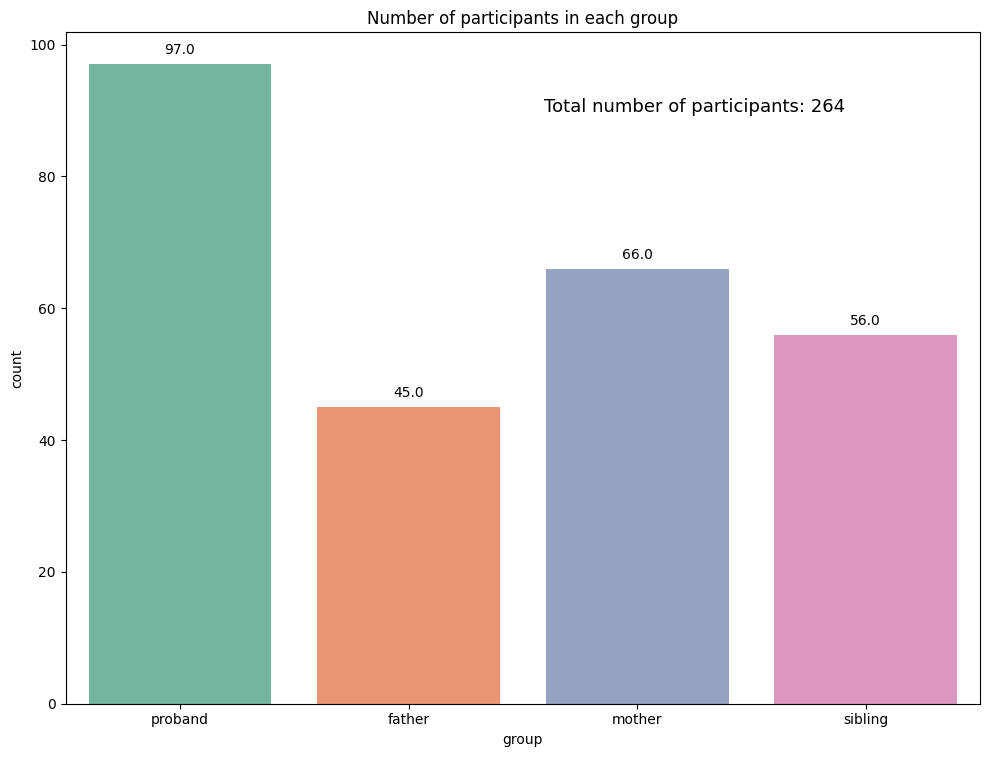

/tmp/ipykernel_3090770/3919742091.py:32: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.




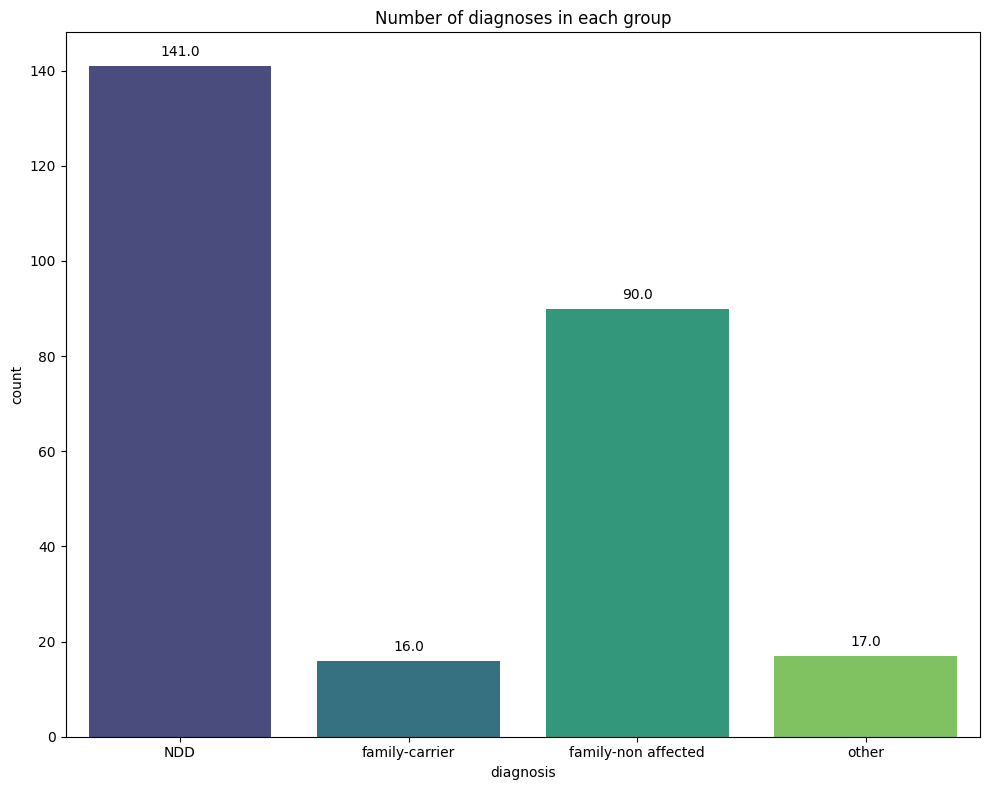

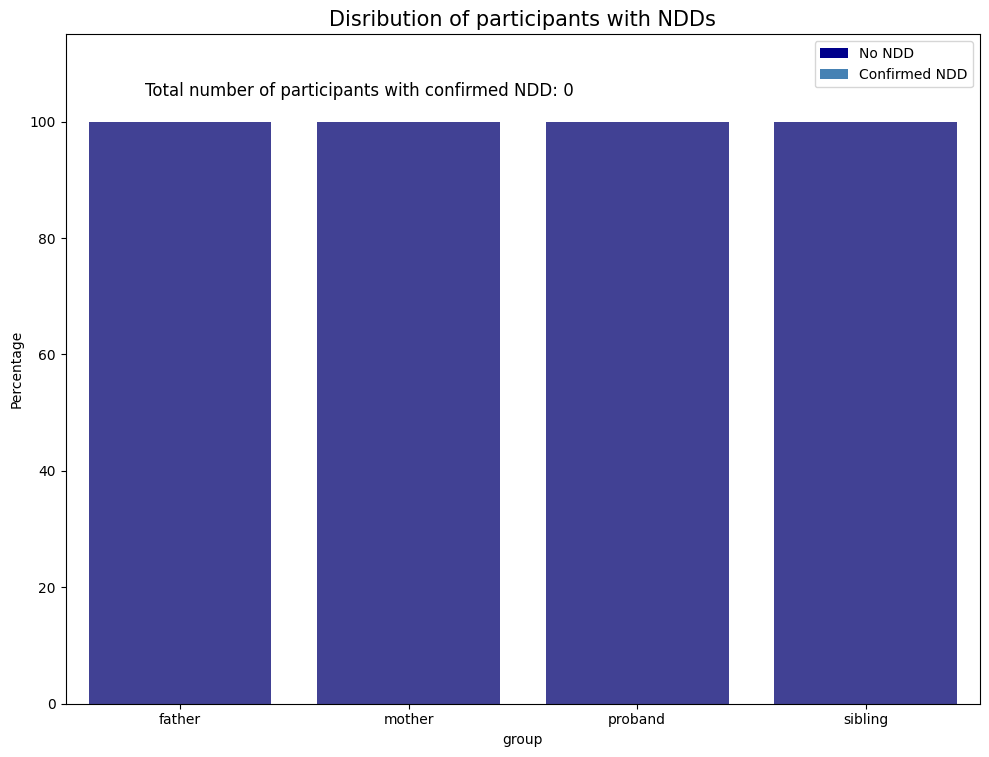

In [289]:
# Save the figures as PDF file
plot_dir = f"../figures/redcap_completion_rates/{date}/total_participants_{date}.pdf"
Path(os.path.dirname(plot_dir)).mkdir(parents=True, exist_ok=True)

    
# Create bar graph of number of participants in each group 

plt.figure(figsize=(10, 8))
ax = sns.countplot(x="group", data=demo_df_attempted, palette='Set2')
plt.title("Number of participants in each group")

# Add count labels on top of the bars

for p in ax.patches:
    ax.annotate(f'{p.get_height()}', (p.get_x() + p.get_width() / 2., p.get_height()), ha='center', va='center', xytext=(0, 10), textcoords='offset points')

# Add subtitle to the top right  with total number of participants

plt.suptitle(f"Total number of participants: {len(demo_df_attempted)}", fontsize=13, x=0.85, y=0.83, ha='right')
plt.tight_layout()
plt.savefig(f"../figures/redcap_completion_rates/{date}/total_participants_{date}.png")
            
plt.show()

doc.add_heading('Total participants', level=4)

doc.add_picture(f"../figures/redcap_completion_rates/{date}/total_participants_{date}.png", width=docx.shared.Inches(6), height=docx.shared.Inches(4))


# Plot the diagnosis distribution
plt.figure(figsize=(10, 8))
ax = sns.countplot(x="diagnosis", data=demo_df_attempted, palette='viridis')
plt.title("Number of diagnoses in each group")

# Add count labels on top of the bars

for p in ax.patches:
    ax.annotate(f'{p.get_height()}', (p.get_x() + p.get_width() / 2., p.get_height()), ha='center', va='center', xytext=(0, 10), textcoords='offset points')

plt.tight_layout()
plt.savefig(f"../figures/redcap_completion_rates/{date}/diagnosis_in_groups{date}.png")
            
plt.show()

doc.add_heading('Number of diagnoses in each group', level=4)

doc.add_picture(f"../figures/redcap_completion_rates/{date}/diagnosis_in_groups{date}.png", width=docx.shared.Inches(6), height=docx.shared.Inches(4))


plt.figure(figsize=(10, 8))

total = demo_df_attempted.groupby("group")["ndd"].count().reset_index()
ndd_positive = demo_df_attempted[demo_df_attempted.ndd==1].groupby("group")["ndd"].count().reset_index()
ndd_positive["ndd"] =[i/j * 100 for i, j in zip(ndd_positive["ndd"], total["ndd"])]
total["ndd"] = [i/j * 100 for i, j in zip(total["ndd"], total["ndd"])]

# Bar chart 1
bar1= sns.barplot(x="group", y="ndd", data=total, color='darkblue', alpha=0.8)

# Bar chart 2
bar2= sns.barplot(x="group", y="ndd", data=ndd_positive, color='steelblue', alpha=0.8)

# Add legend
top_bar = plt.Rectangle((0,0),1,1,fc="darkblue", edgecolor = 'none', label="No NDD")
bottom_bar = plt.Rectangle((0,0),1,1,fc='steelblue',  edgecolor = 'none', label='Confirmed NDD')
plt.legend(handles=[top_bar, bottom_bar])

# Increase the y axis limit
plt.ylim(0,115)
plt.title("Disribution of participants with NDDs", fontsize=15)
plt.ylabel("Percentage")

plt.suptitle(f"Total number of participants with confirmed NDD: {len(demo_df_attempted[demo_df_attempted.ndd==1])}", fontsize=12, x=0.15, y=0.85,  ha='left')
plt.tight_layout()
plt.savefig(f"../figures/redcap_completion_rates/{date}/ndds_per_group_{date}.png")
            
plt.show()

#doc.add_heading('Number of ndds in each group', level=4)

#doc.add_picture(f"../figures/redcap_completion_rates/{date}/ndds_per_group_{date}.png", width=docx.shared.Inches(6), height=docx.shared.Inches(4))



/tmp/ipykernel_3090770/934776276.py:58: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.




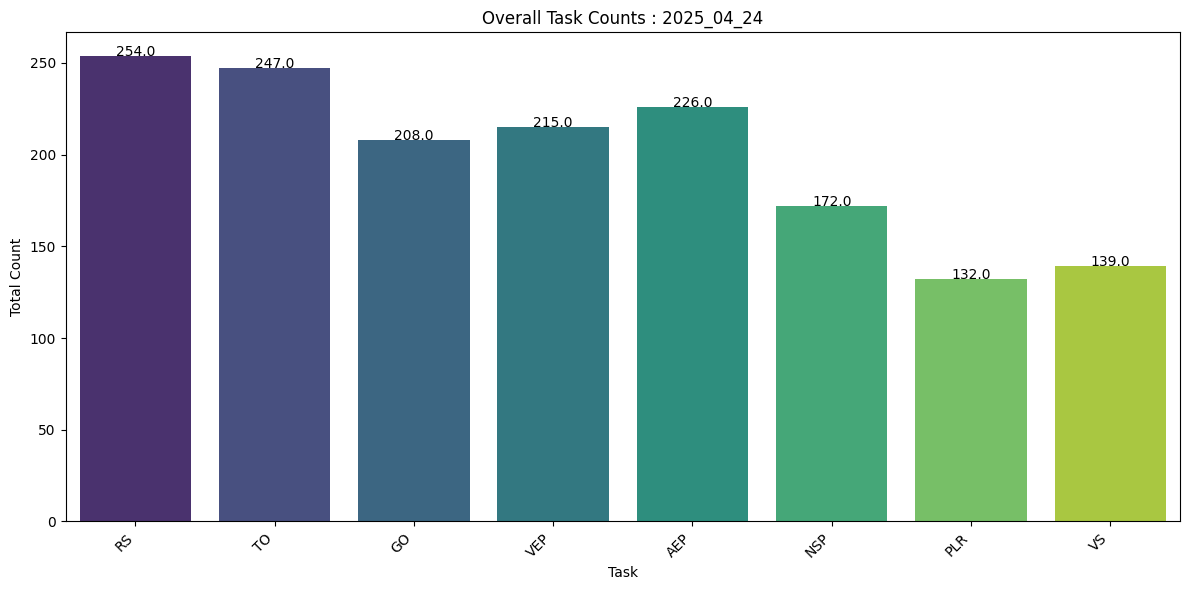

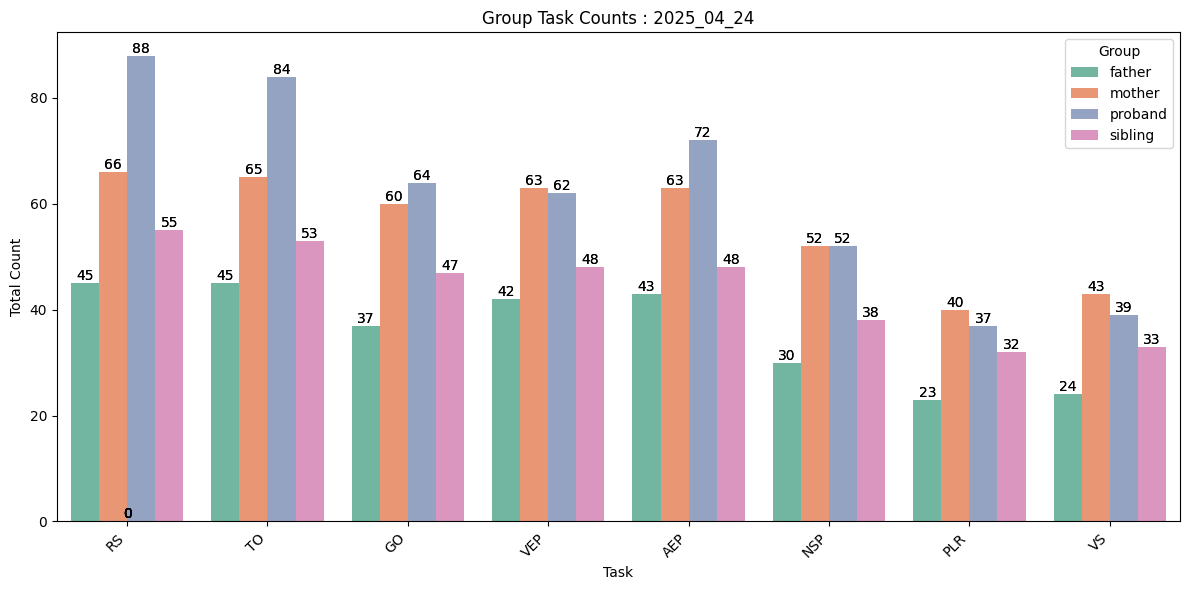

In [290]:
total_task_counts = {}
for task in tasks:
    if task == 'MMN':
        continue
    
    # Count total attempts per task
    task_count = demo_df_attempted[task].sum()
    
    # Count diagnosis-wise task attempts
    diagno_counts = demo_df_attempted.groupby('diagnosis')[task].sum()
    
    # Count group-wise task attempts
    group_counts = demo_df_attempted.groupby('group')[task].sum()
    
    # Identify missing values
    missing_values = demo_df_attempted[task].isna().sum()
    
    total_task_counts[task] = {
        'overall_count': task_count,
        'diagno_counts': diagno_counts.to_dict(), 
        'group_counts': group_counts.to_dict(),
        'missing_values': missing_values
    }

# Prepare data for plotting
overall_data = []
diagno_data = []
group_data = []
for task, counts in total_task_counts.items():
    overall_data.append({
        'Task': task,
        'diagnosis': 'Overall',
        'Count': counts['overall_count']
    })
    for diagno, count in counts['diagno_counts'].items():
        diagno_data.append({
            'Task': task,
            'diagnosis': diagno,
            'Count': count
        })
    for group, count in counts['group_counts'].items():
        group_data.append({
            'Task': task,
            'group': group,
            'Count': count
        })

group_df = pd.DataFrame(group_data)
diagno_df = pd.DataFrame(diagno_data)
overall_df = pd.DataFrame(overall_data)

# Save figures
plot_dir = f"../figures/redcap_task_counts/{date}/task_counts_{date}.pdf"
Path(os.path.dirname(plot_dir)).mkdir(parents=True, exist_ok=True)

# Plot overall task counts
plt.figure(figsize=(12, 6))
sns.barplot(x='Task', y='Count', data=overall_df, palette='viridis')
plt.xticks(rotation=45, ha='right')
plt.title(f"Overall Task Counts : {date}")
plt.ylabel('Total Count')
plt.xlabel('Task')

# Add count text to each bar
for index, row in overall_df.iterrows():
    plt.text(row.name, row.Count, f'{row.Count}', color='black', ha="center")

plt.tight_layout()
plt.savefig(f"../figures/redcap_task_counts/{date}/overall_task_counts_{date}.png")
plt.show()

doc.add_heading('Overall Task Counts', level=4)
doc.add_picture(f"../figures/redcap_task_counts/{date}/overall_task_counts_{date}.png", width=docx.shared.Inches(6), height=docx.shared.Inches(3))
plt.close()

# Plot group-wise task counts
plt.figure(figsize=(12, 6))
sns.barplot(x='Task', y='Count', hue='group', data=group_df, palette='Set2')
ax = sns.barplot(x='Task', y='Count', hue='group', data=group_df, palette='Set2')

# Remove duplicate legends by getting only one unique legend
handles, labels = ax.get_legend_handles_labels()
unique_labels = dict(zip(labels, handles))  # Remove duplicates by keeping unique labels

# Annotate each bar with its corresponding count
for p in ax.patches:
    ax.annotate(f'{int(p.get_height())}', 
                (p.get_x() + p.get_width() / 2., p.get_height()), 
                ha='center', va='bottom', fontsize=10, color='black')

# Set only one legend with unique labels
ax.legend(unique_labels.values(), unique_labels.keys(), title="Group", loc='upper right')

plt.xticks(rotation=45, ha='right')
plt.title(f"Group Task Counts : {date}")
plt.ylabel('Total Count')
plt.xlabel('Task')

plt.tight_layout()

plt.savefig(f"../figures/redcap_task_counts/{date}/group_task_counts_{date}.png")
plt.show()

doc.add_heading('Group Task Counts', level=4)
doc.add_picture(f"../figures/redcap_task_counts/{date}/group_task_counts_{date}.png", width=docx.shared.Inches(6), height=docx.shared.Inches(3))


/tmp/ipykernel_3090770/1815840636.py:61: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.




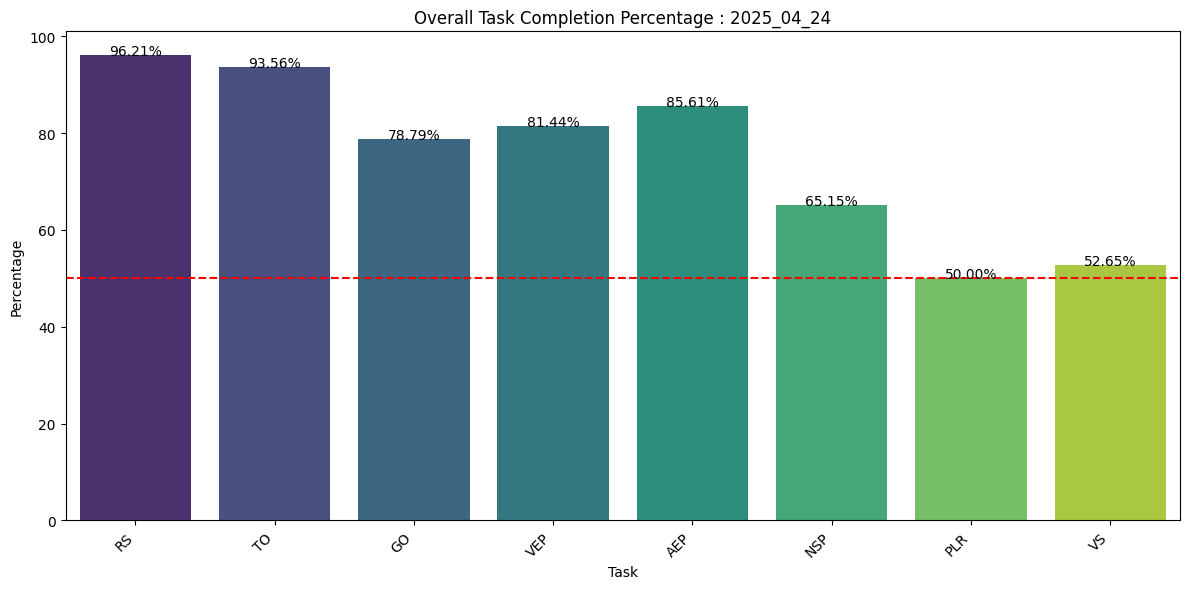

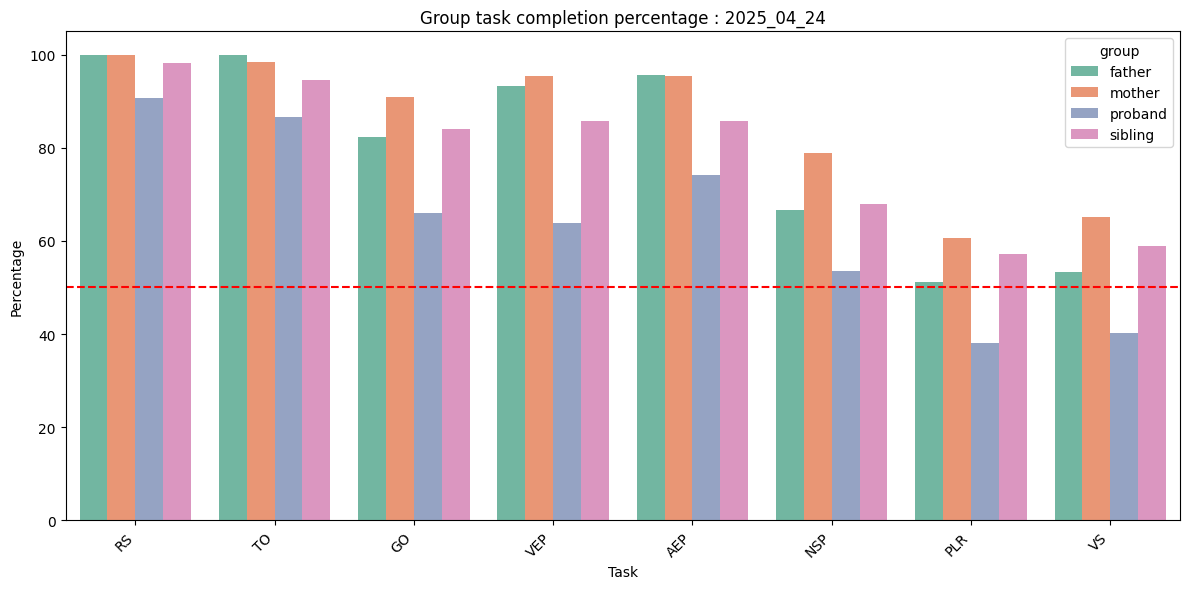

In [291]:

# Calculate task completion percentage for each task
completion_percentages = {}

for task in tasks:
    if task == 'MMN':
        continue
    # Calculate overall percentage of 1s for the task
    task_completion = demo_df_attempted[task].mean() * 100

    # Calculate diagnosis-wise completion percentage
    digno_percentages = demo_df_attempted.groupby('diagnosis')[task].mean() * 100

    # Calculate group-wise completion percentage
    group_percentages = demo_df_attempted.groupby('group')[task].mean() * 100

    completion_percentages[task] = {
        'overall_percentage': task_completion,
        'diagno_percentages': digno_percentages.to_dict(), 
        'group_percentages': group_percentages.to_dict()
    }

# Prepare data for plotting
overall_data = []
diagno_data = []
group_data = []
for task, percentages in completion_percentages.items():
    overall_data.append({
        'Task': task,
        'diagnosis': 'Overall',
        'Percentage': percentages['overall_percentage']
    })
    for diagno, percent in percentages['diagno_percentages'].items():
        diagno_data.append({
            'Task': task,
            'diagnosis': diagno,
            'Percentage': percent
        })
    for group, percent in percentages['group_percentages'].items():
        group_data.append({
            'Task': task,
            'group': group,
            'Percentage': percent
        })

group_df = pd.DataFrame(group_data)


diagno_df = pd.DataFrame(diagno_data)

overall_df = pd.DataFrame(overall_data)


# Save the figures as PDF file
plot_dir = f"../figures/redcap_completion_rates/{date}/completions_rates_{date}.pdf"
Path(os.path.dirname(plot_dir)).mkdir(parents=True, exist_ok=True)



# Plot overall completion percentages
plt.figure(figsize=(12, 6))
sns.barplot(x='Task', y='Percentage', data=overall_df, palette='viridis')
plt.xticks(rotation=45, ha='right')
plt.title(f"Overall Task Completion Percentage : {date}")
plt.ylabel('Percentage')
plt.xlabel('Task')
    # Make horizontal line at 50% completion

# Add completion percentage text to each bar
for index, row in overall_df.iterrows():
    plt.text(row.name, row.Percentage, f'{row.Percentage:.2f}%', color='black', ha="center")

plt.axhline(y=50, color='r', linestyle='--')
plt.tight_layout()
plt.tight_layout()
plt.savefig(f"../figures/redcap_completion_rates/{date}/overall_completions_rates_{date}.png")
            
plt.show()

#doc.add_heading('Overall completion rates', level=4)

#doc.add_picture(f"../figures/redcap_completion_rates/{date}/overall_completions_rates_{date}.png", width=docx.shared.Inches(6), height=docx.shared.Inches(3))


plt.close()


# Plot group-wise completion percentages
plt.figure(figsize=(12, 6))
sns.barplot(x='Task', y='Percentage', hue='group', data=group_df, palette='Set2')
plt.xticks(rotation=45, ha='right')
plt.title(f"Group task completion percentage : {date}")
plt.ylabel('Percentage')
plt.xlabel('Task')
plt.tight_layout()
# Make horizontal line at 50% completion

plt.axhline(y=50, color='r', linestyle='--')
#plt.legend(loc='center left', bbox_to_anchor=(0.85, 0.8))
plt.tight_layout()
plt.savefig(f"../figures/redcap_completion_rates/{date}/Group_completions_rates_{date}.png")
            
plt.show()
#
#doc.add_heading('Overall completion rates', level=4)

#doc.add_picture(f"../figures/redcap_completion_rates/{date}/Group_completions_rates_{date}.png", width=docx.shared.Inches(6), height=docx.shared.Inches(3))





In [292]:
# # Percentage of participants that has completed each task
for task in tasks:
    if task == 'MMN':
        continue
    print(f"Number of participants for {task}: {demo_df_attempted[task].sum() }")

# Create a table of completion rates for each task
completion_table = pd.DataFrame(columns=['Task', f"{date}"])
for task in tasks:
    if task == 'MMN':
        continue
    new_row = pd.DataFrame([{'Task': task, f"{date}": demo_df_attempted[task].sum()}])
    completion_table = pd.concat([completion_table, new_row], ignore_index=True)

completion_dirs= f"../output_dfs/total_per_task/{date}/"
# Print current directory 
if not os.path.exists(completion_dirs):
    os.makedirs(completion_dirs)   

    
# Save all demographic data for all phases
completion_table.to_csv(os.path.join(completion_dirs, f"task_updated_numbers_{date}.csv"), index=False)

Number of participants for RS: 254.0
Number of participants for TO: 247.0
Number of participants for GO: 208.0
Number of participants for VEP: 215.0
Number of participants for AEP: 226.0
Number of participants for NSP: 172.0
Number of participants for PLR: 132.0
Number of participants for VS: 139.0


/tmp/ipykernel_3090770/2113560863.py:13: FutureWarning:

The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.



In [293]:
# Create document that tracks completion rates overtime 
# Initialize a dictionary to store data
completion_table_overtime = completion_table.copy()

# Iterate over all matching files
for file in glob.glob("../output_dfs/total_per_task/*/task_*"):
    completion_rates_dates = pd.read_csv(file)
    file_date = file.split("total_per_task/")[1].split("/")[0]
    
    completion_table_overtime[file_date]=completion_rates_dates[file_date]
    
completion_table_overtime

        

,Task,2025_04_24,2025_03_17,2025_04_14,2025_02_18
0,RS,254.0,240.0,252.0,217
1,TO,247.0,233.0,245.0,209
2,GO,208.0,193.0,205.0,172
3,VEP,215.0,201.0,213.0,181
4,AEP,226.0,213.0,225.0,190
5,NSP,172.0,162.0,170.0,142
6,PLR,132.0,123.0,130.0,106
7,VS,139.0,129.0,137.0,110


In [294]:
# Plot tasks overtime 
# Convert the DataFrame to long format
completion_table_overtime_long = completion_table_overtime.melt(id_vars=["Task"], var_name="Date", value_name="Count")

# Convert the "Date" column to datetime format
completion_table_overtime_long["Date"] = pd.to_datetime(completion_table_overtime_long["Date"], format="%Y_%m_%d")

# Sort by Date for proper plotting
completion_table_overtime_long = completion_table_overtime_long.sort_values("Date")

# Calculate the increase for each task
completion_table_overtime_long["Increase"] = completion_table_overtime_long.groupby("Task")["Count"].diff().fillna(0)
completion_table_overtime_long


,Task,Date,Count,Increase
31,VS,2025-02-18,110.0,0.0
29,NSP,2025-02-18,142.0,0.0
28,AEP,2025-02-18,190.0,0.0
27,VEP,2025-02-18,181.0,0.0
26,GO,2025-02-18,172.0,0.0
25,TO,2025-02-18,209.0,0.0
24,RS,2025-02-18,217.0,0.0
30,PLR,2025-02-18,106.0,0.0
14,PLR,2025-03-17,123.0,17.0
13,NSP,2025-03-17,162.0,20.0


In [295]:
# Plot tasks over time 
# Convert the DataFrame to long format
completion_table_overtime_long = completion_table_overtime.melt(id_vars=["Task"], var_name="Date", value_name="Count")

# Convert the "Date" column to datetime format
completion_table_overtime_long["Date"] = pd.to_datetime(completion_table_overtime_long["Date"], format="%Y_%m_%d")

# Create a new column with just month abbreviations
completion_table_overtime_long["Month"] = completion_table_overtime_long["Date"].dt.strftime('%b')  # e.g., "Feb", "Mar"

# Sort by Date for proper plotting (important for line plots)
completion_table_overtime_long = completion_table_overtime_long.sort_values("Date")

# Calculate the increase for each task
completion_table_overtime_long["Increase"] = completion_table_overtime_long.groupby("Task")["Count"].diff().fillna(0)

completion_table_overtime_long

,Task,Date,Count,Month,Increase
31,VS,2025-02-18,110.0,Feb,0.0
29,NSP,2025-02-18,142.0,Feb,0.0
28,AEP,2025-02-18,190.0,Feb,0.0
27,VEP,2025-02-18,181.0,Feb,0.0
26,GO,2025-02-18,172.0,Feb,0.0
25,TO,2025-02-18,209.0,Feb,0.0
24,RS,2025-02-18,217.0,Feb,0.0
30,PLR,2025-02-18,106.0,Feb,0.0
14,PLR,2025-03-17,123.0,Mar,17.0
13,NSP,2025-03-17,162.0,Mar,20.0


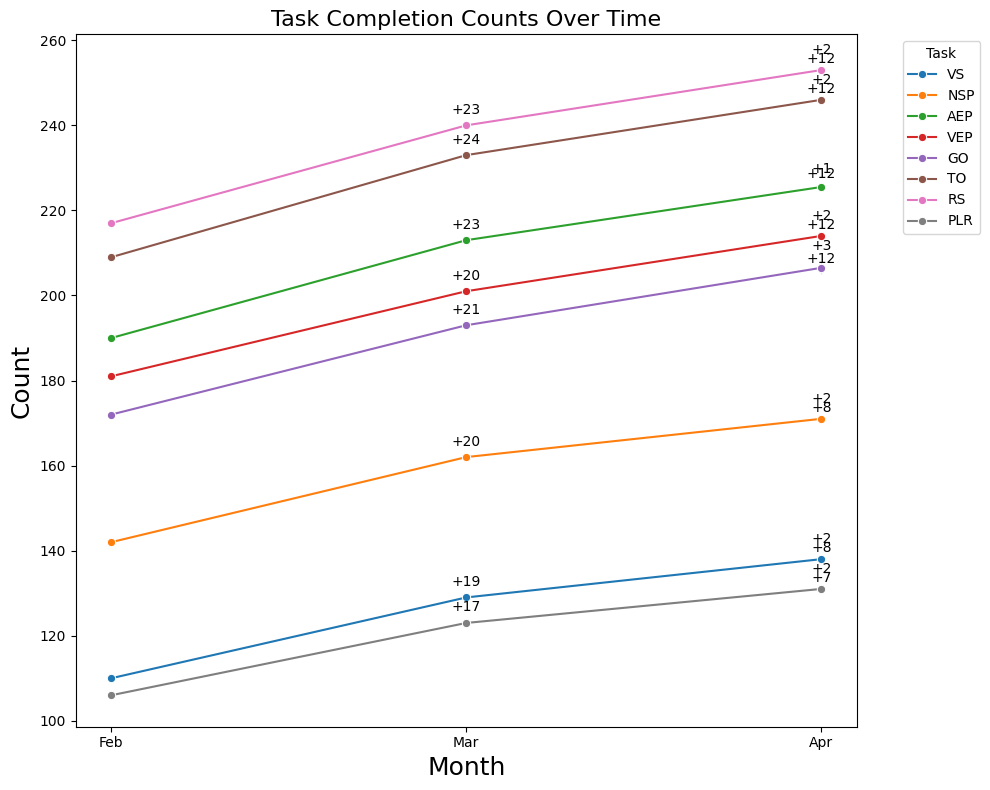

In [296]:
# Plot using Seaborn
plt.figure(figsize=(10, 8))
ax = sns.lineplot(data=completion_table_overtime_long, x="Month", y="Count", hue="Task", marker="o")

# Add annotations for the increase above each line
for task in completion_table_overtime_long["Task"].unique():
    task_data = completion_table_overtime_long[completion_table_overtime_long["Task"] == task]
    for i, row in task_data.iterrows():
        if row["Increase"] != 0:  # Only annotate if there is an increase
            ax.text(row["Month"], row["Count"] + 2, f"+{int(row['Increase'])}", 
                    ha='center', va='bottom', fontsize=10, color='black')

# Add labels and title
plt.title("Task Completion Counts Over Time", fontsize=16)
plt.xlabel("Month", fontsize=18)
plt.ylabel("Count", fontsize=18)
plt.xticks(rotation=0)  # Rotate x-axis labels for better readability
plt.legend(title="Task", bbox_to_anchor=(1.05, 1), loc='upper left')  # Move legend outside the plot
plt.tight_layout()  # Adjust layout to prevent overlap
plt.show()

# 3. Tracking EEG-ET pipeline outputs

#### Export experimental data

In [297]:
output_dir= f"../output_dfs/pipeline_outputs/{date}"
# Print current directory 
print("This is the current directory: ", os.getcwd())
if not os.path.exists(output_dir):
    os.makedirs(output_dir)


This is the current directory:  /lustre06/project/6030602/q1k/experimental/tracking/code


In [298]:
tasks=["RS", "TO", "AEP", "GO", "PLR", "VEP", "VS", "NSP"]

In [299]:
bids_subject= []
pylossless_subjects=[]
et_sync_loss_subs=[]
task_segment_counts = {}
segmented_subs=[]
task_counts = {}
raw_files=[]

post_proc_subs=[]

raw_subject_per_task={}
raw_subs_per_task_overall=[]

bids_subject_per_task={}
bids_subs_per_task_overall=[]

pylossless_subs_per_task={}
pylossless_loss_subs_per_task_overall=[]

post_proc_subs_per_task={}
post_proc_subs_per_task_overall=[]

sync_loss_subs_per_task={}
sync_loss_subs_per_task_overall=[]

autoreject_subs=[]
autorej_segment_counts={}

demo_df=demo_df_attempted.copy()
sites = ["HSJ", "MHC"]

# Derive number of raw files
for site in sites:
    for file in glob.glob(f"../../../../Sharing/CHUSJ-Q1K-PILOT/experimental/{site}/sourcedata/eeg/Q*"):
        if "__" in file: 
            file = file.replace("__", "_")
      
        site_part = file.split(site + "_")
        if len(site_part)==1:
            site_part = file.split("HSJ" + "_")
            print("Exception because participant: ", file, "had different sites")
        if "Pilots" in site_part:
            continue      
        alphanum = file.split("_")[-1]
        family_id = file.split("_")[-2][-4:]
        subject_id = family_id + alphanum
        raw_files.append(subject_id)

for task in tasks:
    count = 0
    for file in glob.glob(f"../../../../Sharing/CHUSJ-Q1K-PILOT/experimental/*/sourcedata/eeg/Q*/Q1K*{task}_*.mff", recursive=False):
        #print(file)
        if "__" in file: 
            continue
        if "Pilots" in file:
            continue      
        parts=parts = file.split('_')
        fam_id=parts[2][2:]
        if "-" in parts[2]:
            fam_id2=fam_id.split("-")[1]
            fam_id=fam_id2
            if "-" in fam_id2:
                fam_id=fam_id2.split("-")[1]
            #print(parts[2], fam_id2, fam_id)
        fam_id = fam_id.zfill(4)
        if "0025" in fam_id:
            subject_id=parts[3]+ parts[4].split("/")[0]
          #  print(subject_id,parts)
        # Split by underscore
        else:
            subject_id =fam_id  + parts[3].split("/")[0]
      #  print(file)
        raw_subs_per_task_overall.append([subject_id, task])
        count += 1
    raw_subject_per_task[task] = task_counts.get(task, 0) + count

    # Derive number who completed BIDS
for task in tasks:
    count = 0
    for file in glob.glob(f"../../sub*/*/eeg/*{task}*.edf", recursive=False):
        subject_id = file.split('-')[1].split('/')[0]
        bids_subs_per_task_overall.append([subject_id, task])
        count += 1
    bids_subject_per_task[task] = task_counts.get(task, 0) + count

   # Derive number who completed Pylosless    
for task in tasks:
    count = 0
    for file in glob.glob(f"../../derivatives/pylossless/sub*/*/eeg/*{task}*.edf", recursive=False):
        subject_id = file.split('-')[1].split('/')[0]
        pylossless_loss_subs_per_task_overall.append([subject_id, task])
        count += 1
    pylossless_subs_per_task[task] = task_counts.get(task, 0) + count
   
    # Derive number who compeleted segmentation

for task in tasks:
    count = 0
    for file in glob.glob(f"../../derivatives/pylossless/derivatives/sync_loss/derivatives/segment/epoch_fif_files/{task}/sub*", recursive=False):
        subject_id = file.split('-')[1].split('_')[0]
        segmented_subs.append([subject_id, task])
        count += 1
    task_segment_counts[task] = task_counts.get(task, 0) + count

    # Derive number who completed synclosss
    
for task in tasks:
    count = 0
    for file in glob.glob(f"../../derivatives/pylossless/derivatives/sync_loss/sub*/*/eeg/*{task}*.edf", recursive=False):
       # print(file)
        subject_id = file.split('-')[1].split('/')[0]
        sync_loss_subs_per_task_overall.append([subject_id, task])
        count += 1
    sync_loss_subs_per_task[task] = task_counts.get(task, 0) + count

    # Derive those who completed Autoreject
    
for task in tasks:
    count = 0
    for file in glob.glob(f"../../derivatives/pylossless/derivatives/sync_loss/derivatives/segment/derivatives/autorej/epoch_fif_files/{task}/sub*", recursive=False):
        subject_id = file.split('-')[1].split('_')[0]
        autoreject_subs.append([subject_id, task])
        count += 1
    autorej_segment_counts[task] = task_counts.get(task, 0) + count
    
    # Derive those who reached post processing

for task in tasks:
    count = 0
    for file in glob.glob(f"../../derivatives/pylossless/derivatives/sync_loss/derivatives/segment/derivatives/autorej/epoch_fif_files/{task}/sub*", recursive=False):
        subject_id = file.split('-')[1].split('_')[0]
        post_proc_subs.append([subject_id, task])
        count += 1
    task_counts[task] = task_counts.get(task, 0) + count

# Store consneted information: 

# Create subjectID as Q1K Record id if not none
demo_df.loc[pd.isna(demo_df["bids_id"]), "bids_id"] = "999"
consented_ids= demo_df.bids_id.unique()
# Store lists in a dictionary
subject_dict = {
    "Consented": consented_ids,
    "Raw": raw_files,
    "BIDS": bids_subject,
    "Pylossless": pylossless_subjects,
    "ET_sync_loss": et_sync_loss_subs,
    "Segmentation": list(set([sub[0] for sub in segmented_subs])),
    "Autoreject": list(set([sub[0] for sub in autoreject_subs])),  # Extracting unique subject IDs only
    "Post_proc": list(set([sub[0] for sub in post_proc_subs])) 
}


# Print task completion counts
for task, count in task_counts.items():
    print(f"Total number who reached autorejection step for {task}: {count}")
    

Exception because participant:  ../../../../Sharing/CHUSJ-Q1K-PILOT/experimental/MHC/sourcedata/eeg/Q1K_HSJ_100119_M1 had different sites
Total number who reached autorejection step for RS: 186
Total number who reached autorejection step for TO: 138
Total number who reached autorejection step for AEP: 161
Total number who reached autorejection step for GO: 140
Total number who reached autorejection step for PLR: 69
Total number who reached autorejection step for VEP: 152
Total number who reached autorejection step for VS: 96
Total number who reached autorejection step for NSP: 0


In [300]:
demo_df.columns

Index(['q1k_ID', 'group', 'Diagnosis', 'eeg_attempt', 'site', 'diagnosis',
       'eeg_age', 'eeg_sex', 'record_id', 'RS_fail_reason',
       'EEG_failed_attempt_reason', 'EEG-ET Date:', 'RS', 'TO', 'GO', 'VEP',
       'AEP', 'NSP', 'PLR', 'VS', 'Event Name', 'age', 'sex', 'cog_imp',
       'fasd', 'learn_dis', 'motor_dis', 'other_ndd1', 'other_ndd2',
       'anxiety_dis', 'depression_dis', 'bipolar_dis', 'ocd', 'touretette',
       'psychosis', 'schizophrenia', 'substance_abuse', 'epilepsy', 'other_1',
       'other_2', 'adhd', 'hearing_dis', 'visual_dis', 'physical_dis',
       'genetic_dis', 'other_3', 'other_diagnoses', 'genetic_dis_alt', 'ndd',
       'adhd_alt', 'language_dis', 'lang_dis_3', 'asd',
       'Attention Deficit Hyperactivity Disorder.3', 'Language Impairment',
       'phase_3_consented', 'phase_2_consented', 'q1k_relative_id',
       'age_group', 'bids_id', 'participant_id'],
      dtype='object')

In [301]:
raw_subject_per_task

{'RS': 208,
 'TO': 156,
 'AEP': 175,
 'GO': 166,
 'PLR': 104,
 'VEP': 172,
 'VS': 113,
 'NSP': 141}

In [302]:
bids_subject_per_task

{'RS': 197,
 'TO': 148,
 'AEP': 169,
 'GO': 147,
 'PLR': 89,
 'VEP': 172,
 'VS': 98,
 'NSP': 121}

In [303]:
pylossless_subs_per_task

{'RS': 192,
 'TO': 140,
 'AEP': 168,
 'GO': 145,
 'PLR': 88,
 'VEP': 172,
 'VS': 97,
 'NSP': 119}

In [304]:
sync_loss_subs_per_task


{'RS': 191,
 'TO': 140,
 'AEP': 163,
 'GO': 140,
 'PLR': 69,
 'VEP': 169,
 'VS': 96,
 'NSP': 117}

In [305]:
task_segment_counts

{'RS': 186,
 'TO': 138,
 'AEP': 161,
 'GO': 141,
 'PLR': 69,
 'VEP': 152,
 'VS': 97,
 'NSP': 0}

In [306]:
autorej_segment_counts

{'RS': 186,
 'TO': 138,
 'AEP': 161,
 'GO': 140,
 'PLR': 69,
 'VEP': 152,
 'VS': 96,
 'NSP': 0}

In [307]:
demo_df_attempted.columns

Index(['q1k_ID', 'group', 'Diagnosis', 'eeg_attempt', 'site', 'diagnosis',
       'eeg_age', 'eeg_sex', 'record_id', 'RS_fail_reason',
       'EEG_failed_attempt_reason', 'EEG-ET Date:', 'RS', 'TO', 'GO', 'VEP',
       'AEP', 'NSP', 'PLR', 'VS', 'Event Name', 'age', 'sex', 'cog_imp',
       'fasd', 'learn_dis', 'motor_dis', 'other_ndd1', 'other_ndd2',
       'anxiety_dis', 'depression_dis', 'bipolar_dis', 'ocd', 'touretette',
       'psychosis', 'schizophrenia', 'substance_abuse', 'epilepsy', 'other_1',
       'other_2', 'adhd', 'hearing_dis', 'visual_dis', 'physical_dis',
       'genetic_dis', 'other_3', 'other_diagnoses', 'genetic_dis_alt', 'ndd',
       'adhd_alt', 'language_dis', 'lang_dis_3', 'asd',
       'Attention Deficit Hyperactivity Disorder.3', 'Language Impairment',
       'phase_3_consented', 'phase_2_consented', 'q1k_relative_id',
       'age_group', 'bids_id', 'participant_id'],
      dtype='object')

In [308]:
demo_df_attempted['EEG-ET Date:'].value_counts()

EEG-ET Date:
2024-03-07    5
2024-06-25    5
2024-05-24    5
2025-01-22    4
2024-07-18    4
             ..
2025-02-05    1
2024-12-11    1
2024-03-28    1
2024-06-21    1
2025-04-11    1
Name: count, Length: 114, dtype: int64

In [326]:
q1k_df

,q1k_ID,group,Diagnosis,eeg_attempt,site,diagnosis,eeg_age,eeg_sex,record_id,RS_fail_reason,EEG_failed_attempt_reason,EEG-ET Date:,RS,TO,GO,VEP,AEP,NSP,PLR,VS
0,Q1K_HSJ_10040_P,proband,nan,0,hsj,other,NaN,0,40,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,Q1K_HSJ_10040_M1,mother,nan,0,hsj,other,NaN,0,41,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,Q1K_MHC_20042_P,proband,Neurodevelopmental disorder,1,mni,NDD,30.973942,Female,42,0,0,2024-08-09,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
3,Q1K_HSJ_10043_P,proband,"Neurodevelopmental disorder,Genetic carrier",1,hsj,NDD,16.906576,Male,43,0,0,2024-03-28,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
4,Q1K_HSJ_10043_F1,father,Genetic carrier,1,hsj,family-carrier,58.133865,Male,45,0,0,2024-05-31,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
298,Q1K_HSJ_1525-1209_M1,mother,Control (no genetic or neurodev disorder),1,hsj,family-non affected,50.774485,Female,525-1210,0,0,2025-03-19,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0
299,Q1K_HSJ_1525-1212_P,proband,"Neurodevelopmental disorder,Genetic carrier,Ot...",1,hsj,NDD,6.864047,Female,525-1212,0,0,2025-03-06,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0
300,Q1K_HSJ_1525-1212_M1,mother,Neurodevelopmental disorder,1,hsj,NDD,26.086778,Female,525-1213,0,0,2025-03-06,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
301,Q1K_HSJ_1525-1192_S1,sibling,Neurodevelopmental disorder,1,hsj,NDD,11.296604,Male,525-1214,0,0,2025-03-07,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0


In [333]:
eeg_attempted=[]
eeg_visit=[]
# Change ids to match bids
 
demo["bids_id"]=np.nan
for sub_id in demo.q1k_relative_id.unique():
    if pd.isna(sub_id):
        continue
    if "test" in sub_id:
        continue
   # print(sub_id)
    new_id=q1k_to_BIDS(sub_id)
   # print(sub_id, new_id)
    demo.loc[demo.q1k_relative_id==sub_id, "bids_id"]=new_id

q1k_df["bids_id"]=np.nan
for sub_id in q1k_df.q1k_ID.unique():
    if pd.isna(sub_id):
        continue
    new_id=q1k_to_BIDS(sub_id)
    #print(sub_id, new_id)
    q1k_df.loc[q1k_df.q1k_ID==sub_id, "bids_id"]=new_id
    

# Load demographic data and get visit
for id in q1k_df["bids_id"].unique():
    if q1k_df.loc[q1k_df.bids_id == id, 'EEG-ET Date:'].values[0]!=0:
        eeg_visit.append(id)
# Get EEG attempted
    if q1k_df.loc[q1k_df.bids_id == id, 'eeg_attempt'].values[0]==1:
        eeg_attempted.append(id)

    

/tmp/ipykernel_3090770/115955105.py:14: FutureWarning:

Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '0100P' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.

/tmp/ipykernel_3090770/115955105.py:22: FutureWarning:

Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '0040P' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.



Invalid ID format for sub Q1K_MHC_200315_P_. Should be 'XXX_XX' or 'XXXX_XX' or 'XXX_X' or 'XXXX_XX'.
Invalid ID format for sub Q1K_MHC_200315_M1_. Should be 'XXX_XX' or 'XXXX_XX' or 'XXX_X' or 'XXXX_XX'.


In [334]:
len(eeg_visit)

285

In [335]:
len(eeg_attempted)

264

In [336]:
# Create a DataFrame
eeg_visit_df=pd.DataFrame({"subject_id": eeg_visit, "EEG visit": 1})
eeg_attempted_df=pd.DataFrame({"subject_id": eeg_attempted, "EEG attempted": 1})

phase_3_ids=demo[demo.phase_3_consented=='Complete'].bids_id.unique()
phase_3_df=pd.DataFrame({"subject_id": phase_3_ids, "Phase 3 consented": 1})
raw_df=pd.DataFrame({"subject_id": raw_files, "EEG Raw Files": 1})
raw_df["EEG Raw Files"]=raw_df["EEG Raw Files"].astype(float)
bids_df = pd.DataFrame({"subject_id": bids_subject, "BIDS": 1})
pylossless_df = pd.DataFrame({"subject_id": pylossless_subjects, "Pylossless": 1})
et_sync_df = pd.DataFrame({"subject_id": et_sync_loss_subs, "ET_sync_loss": 1})
segment_df = pd.DataFrame(segmented_subs, columns=["subject_id", "Task"])
segment_df["Segmentation"]=1
post_proc_df = pd.DataFrame(autoreject_subs, columns=["subject_id", "Task"])
post_proc_df["Autoreject"] = 1

# Add task-specific columns
for task in tasks:
    post_proc_df[task] = post_proc_df["Task"].apply(lambda x: 1 if x == task else 0)

post_proc_df.drop(columns=["Task"], inplace=True)
# Merge all dataframes on subject_id

#final_df = eeg_attempted_df.merge(raw_df, on="subject_id", how="outer")

final_df = phase_3_df.merge(eeg_visit_df, on="subject_id", how="outer")
final_df = final_df.merge(eeg_attempted_df, on="subject_id", how="outer")
final_df = final_df.merge(raw_df, on="subject_id", how="outer")
final_df = final_df.merge(bids_df, on="subject_id", how="outer")
final_df = final_df.merge(pylossless_df, on="subject_id" , how="outer")
final_df = final_df.merge(et_sync_df, on="subject_id",  how="outer")
final_df = final_df.merge(segment_df, on="subject_id",  how="outer")
final_df = final_df.merge(post_proc_df, on="subject_id", how= "left")
final_df = final_df.drop_duplicates(subset=['subject_id'])
# Fill NaN with 0 (indicating incomplete stages)
final_df.fillna(0, inplace=True)
final_df

,subject_id,Phase 3 consented,EEG visit,EEG attempted,EEG Raw Files,BIDS,Pylossless,ET_sync_loss,Task,Segmentation,Autoreject,RS
0,0021P,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0.0,0.0,0.0
1,0040M1,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0.0,0.0,0.0
2,0040P,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0.0,0.0,0.0
3,0042P,0.0,1.0,1.0,1.0,0.0,0.0,0.0,RS,1.0,1.0,1.0
28,0043F1,1.0,1.0,1.0,1.0,0.0,0.0,0.0,RS,1.0,1.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...
5290,1218P,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0.0,0.0,0.0
5291,1221P,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0,0.0,0.0,0.0
5292,Q1K_MHC_200315_M1_,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0,0.0,0.0,0.0
5293,Q1K_MHC_200315_P_,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0,0.0,0.0,0.0


In [337]:
steps = ["Phase 3 consented", "EEG visit", "EEG attempted","EEG Raw Files","BIDS", "Pylossless", "ET_sync_loss", "Segmentation", "Autoreject"]

final_df['Last_stage'] = final_df[steps].apply(
    lambda row: next((step for step in reversed(steps) if row[step] == 1), 'none'),
    axis=1
)



final_df['discrepancy'] = final_df.apply(has_skipped_steps, axis=1)

final_df

,subject_id,Phase 3 consented,EEG visit,EEG attempted,EEG Raw Files,BIDS,Pylossless,ET_sync_loss,Task,Segmentation,Autoreject,RS,Last_stage,discrepancy
0,0021P,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0.0,0.0,0.0,Phase 3 consented,False
1,0040M1,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0.0,0.0,0.0,Phase 3 consented,False
2,0040P,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0.0,0.0,0.0,Phase 3 consented,False
3,0042P,0.0,1.0,1.0,1.0,0.0,0.0,0.0,RS,1.0,1.0,1.0,Autoreject,True
28,0043F1,1.0,1.0,1.0,1.0,0.0,0.0,0.0,RS,1.0,1.0,1.0,Autoreject,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5290,1218P,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0.0,0.0,0.0,Phase 3 consented,False
5291,1221P,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0,0.0,0.0,0.0,EEG attempted,False
5292,Q1K_MHC_200315_M1_,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0,0.0,0.0,0.0,EEG attempted,False
5293,Q1K_MHC_200315_P_,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0,0.0,0.0,0.0,EEG attempted,False


In [338]:
# Get unique subject IDs from each dataframe
eeg_subjects = set(eeg_attempted_df['subject_id'])
raw_subjects = set(raw_df['subject_id'])

# Find common and unique subject IDs
common_ids = eeg_subjects & raw_subjects  # Intersection (IDs in both)
unique_to_eeg = eeg_subjects - raw_subjects  # IDs only in eeg_attempted_df
unique_to_raw = raw_subjects - eeg_subjects  # IDs only in raw_df

# Convert to lists if needed
common_ids = list(common_ids)
unique_to_eeg = list(unique_to_eeg)
unique_to_raw = list(unique_to_raw)

# Print or use as needed
#print(f"Common IDs: {common_ids}")
print(f"Unique to EEG: {unique_to_eeg}")

print(f"Unique to RAW: {unique_to_raw}")

Unique to EEG: ['1195S2', 'Q1K_MHC_200315_P_', '0227S4', '1156P', '1203F1', '1192P', '1169F1', 'Q1K_MHC_200315_M1_', '0227P', '1203P', '1209M1', '1159P', '1203S3', '1159S1', '1192F1', '1152S1', '0227M1', '1187P', '1212P', '1192M1', '1169P', '1200P', '1195S1', '1166F1', '1166P', '1166M1', '1130S2', '0108P', '0227S2', '1187M1', '1209P', '1182M1', '1203S2', '1182F1', '0086P', '0227S1', '1212M1', '1061M1', '1130S1', '1159S2', '1162S1', '1221P', '1192S1', '1182P', '1130P', '1152P', '1169M1', '1195P', '1177P', '1156F1', '0227F1']
Unique to RAW: ['1061M']


In [339]:
# Verify those that have contradicgoru information

In [340]:
final_df.loc[(final_df["ET_sync_loss"]==1) & (final_df["Segmentation"] ==0)]

,subject_id,Phase 3 consented,EEG visit,EEG attempted,EEG Raw Files,BIDS,Pylossless,ET_sync_loss,Task,Segmentation,Autoreject,RS,Last_stage,discrepancy


# 4. Create data loss df for those participants who have consented

In [341]:
q1k_data_loss_tracker.loc[q1k_data_loss_tracker.record_id=="93"]

,record_id,Event Name,Q1K Registry ID:,et_id,Birthdate,eeg_age,eeg_sex,Diagnosis,EEG-ET Date:,Participant's code for resting state :,...,AS,FSP,MMN,eeg_attempt,q1k_ID,RS_fail_reason,EEG_failed_attempt_reason,group,site,diagnosis
26,93,Phase 3 (Arm 1: Phase 2),NaN,Q093_P,2019-04-30,NaN,Male,"Neurodevelopmental disorder,Genetic carrier",2024-04-23,Q1K_HSJ_10093_P_RS,...,0.0,NaN,NaN,0,Q1K_HSJ_10093_P,NaN,Non-compliance,proband,hsj,NDD


In [342]:
# Select important columns from the EEG-ET Completed REDCap report

data_loss_tracker=q1k_data_loss_tracker[['q1k_ID', 'et_id','record_id','Birthdate','EEG-ET Date:', 'eeg_age', 'group', 'site',
       'eeg_attempt','RS_fail_reason', 'EEG_failed_attempt_reason']]

# Create data with those that have consented phase 3 from demo df
demo_data_loss_tracker=demo[['record_id','q1k_relative_id','phase_3_consented', 'sex']]
demo_data_loss_tracker=demo_data_loss_tracker.loc[demo_data_loss_tracker.phase_3_consented == "Complete"]

# Merge both dataframes
data_loss_tracker=data_loss_tracker.merge(demo_data_loss_tracker, on="record_id", how="outer")

# Change ids to match bids
data_loss_tracker["bids_id"]=np.nan
for subject_id in data_loss_tracker.q1k_ID.unique():
    if pd.isna(subject_id):
        continue
    new_id=q1k_to_BIDS(subject_id)
    
    #print(subject_id, new_id)
    data_loss_tracker.loc[data_loss_tracker.q1k_ID==subject_id, "bids_id"]=new_id
    
    
data_loss_tracker["subject_id"]=data_loss_tracker["bids_id"]
data_loss_tracker

Invalid ID format for sub Q1K_MHC_200315_P_. Should be 'XXX_XX' or 'XXXX_XX' or 'XXX_X' or 'XXXX_XX'.
Invalid ID format for sub Q1K_MHC_200315_M1_. Should be 'XXX_XX' or 'XXXX_XX' or 'XXX_X' or 'XXXX_XX'.


/tmp/ipykernel_3090770/2939227470.py:21: FutureWarning:

Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '0100P' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.



,q1k_ID,et_id,record_id,Birthdate,EEG-ET Date:,eeg_age,group,site,eeg_attempt,RS_fail_reason,EEG_failed_attempt_reason,q1k_relative_id,phase_3_consented,sex,bids_id,subject_id
0,Q1K_HSJ_100100_P,Q100_P,100,2017-08-03,2024-02-23,6.557401,proband,hsj,1.0,NaN,NaN,Q1K_HSJ_100100_P,Complete,Female,0100P,0100P
1,Q1K_HSJ_100100_S1,Q100_S1,101,2020-10-17,2024-02-23,3.351312,sibling,hsj,1.0,NaN,NaN,Q1K_HSJ_100100_S1,Complete,Male,0100S1,0100S1
2,NaN,NaN,102,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Q1K_HSJ_100100_M1,Complete,Female,NaN,NaN
3,Q1K_HSJ_100100_F1,Q100_F1,103,1994-01-11,2024-02-23,30.116977,father,hsj,1.0,NaN,NaN,Q1K_HSJ_100100_F1,Complete,Male,0100F1,0100F1
4,Q1K_HSJ_100104_P,Q104_P,104,1988-04-18,2024-07-02,36.206082,proband,hsj,1.0,NaN,NaN,Q1K_HSJ_100104_P,Complete,Female,0104P,0104P
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
404,NaN,NaN,94,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Q1K_HSJ_10093_M1,Complete,Female,NaN,NaN
405,Q1K_HSJ_10093_O1,Q093_O1,95,1967-03-29,2024-04-23,57.071557,sibling,hsj,1.0,NaN,NaN,Q1K_HSJ_10093_O1,Complete,Female,0093O1,0093O1
406,Q1K_HSJ_10097_P,NaN,97,2016-02-14,NaN,NaN,proband,hsj,0.0,NaN,Ne lâchait pas son jouet à mâcher pendant les ...,Q1K_HSJ_10097_P,Complete,Male,0097P,0097P
407,Q1K_HSJ_10097_M1,NaN,98,1986-04-02,NaN,NaN,mother,hsj,0.0,NaN,NaN,Q1K_HSJ_10097_M1,Complete,Female,0097M1,0097M1


In [343]:
data_loss_tracker.loc[data_loss_tracker.record_id=="93"]

,q1k_ID,et_id,record_id,Birthdate,EEG-ET Date:,eeg_age,group,site,eeg_attempt,RS_fail_reason,EEG_failed_attempt_reason,q1k_relative_id,phase_3_consented,sex,bids_id,subject_id
403,Q1K_HSJ_10093_P,Q093_P,93,2019-04-30,2024-04-23,NaN,proband,hsj,0.0,NaN,Non-compliance,Q1K_HSJ_10093_P,Complete,Male,0093P,0093P


In [344]:
tasks=['RS', 'TO', 'AEP', 'GO', 'PLR', 'VEP', 'NSP', 'VS']

# 5. Create demographics table and sankey graphs per task

In [345]:
steps = ["Phase 3 consented", "EEG Visit", "EEG Attempted","EEG Raw Files","BIDS", "Pylossless", "ET_sync_loss", "Segmentation", "Autoreject"]
for task in tasks:
    
    # Create a DataFrame
    eeg_visit_df=pd.DataFrame({"subject_id": eeg_visit, "EEG Visit": 1})
    eeg_attempted_df=pd.DataFrame({"subject_id": eeg_attempted, "EEG Attempted": 1})

    phase_3_ids=demo[demo.phase_3_consented=='Complete'].bids_id.unique()
    phase_3_df=pd.DataFrame({"subject_id": phase_3_ids, "Phase 3 consented": 1})

    raw_df = pd.DataFrame(raw_subs_per_task_overall, columns=["subject_id", "Task"])
    raw_df["EEG Raw Files"] = 1
    raw_df=raw_df.loc[raw_df.Task==task]
    raw_df.drop(columns="Task", inplace=True) 
    
    bids_df = pd.DataFrame(bids_subs_per_task_overall, columns=["subject_id", "Task"])
    bids_df["BIDS"] = 1
    bids_df=bids_df.loc[bids_df.Task==task]
    bids_df.drop(columns="Task", inplace=True)  
       
    
    pylossless_df = pd.DataFrame(pylossless_loss_subs_per_task_overall, columns=["subject_id", "Task"])
    pylossless_df["Pylossless"]=1
    pylossless_df=pylossless_df.loc[pylossless_df.Task==task]
    pylossless_df.drop(columns="Task", inplace=True)  

    et_sync_df = pd.DataFrame(sync_loss_subs_per_task_overall, columns=["subject_id", "Task"])
    et_sync_df["ET_sync_loss"]=1
    et_sync_df=et_sync_df.loc[et_sync_df.Task==task]
    et_sync_df.drop(columns="Task", inplace=True)  
    
    segment_df = pd.DataFrame(segmented_subs, columns=["subject_id", "Task"])
    segment_df["Segmentation"]=1
    segment_df=segment_df.loc[segment_df.Task==task]
    
    
    post_proc_df = pd.DataFrame(autoreject_subs, columns=["subject_id", "Task"])
    post_proc_df["Autoreject"] = 1
    post_proc_df=post_proc_df.loc[post_proc_df.Task==task]
    post_proc_df.drop(columns="Task", inplace=True)


    # Merge all dataframes on subject_id
    final_df = phase_3_df.merge(eeg_attempted_df, on="subject_id", how="outer")
    final_df = final_df.merge(eeg_visit_df, on="subject_id", how="outer")

    final_df = final_df.merge(raw_df, on="subject_id", how="outer")
    final_df = final_df.merge(bids_df, on="subject_id", how="outer")
    final_df = final_df.merge(pylossless_df, on="subject_id" , how="outer")
    final_df = final_df.merge(et_sync_df, on="subject_id",  how="outer")
    final_df = final_df.merge(segment_df, on="subject_id",  how="outer")
    final_df = final_df.merge(post_proc_df, on="subject_id", how= "left")
    final_df = final_df.drop_duplicates(subset=['subject_id'])
    # Fill NaN with 0 (indicating incomplete stages)
    final_df.fillna(0, inplace=True)
    
    final_df['Last_stage'] = final_df[steps].apply(
        lambda row: next((step for step in reversed(steps) if row[step] == 1), 'none'),
        axis=1
    )



    final_df['discrepancy'] = final_df.apply(has_skipped_steps, axis=1)
    

    if task == "NA": 
        print("This task has not been analyzed with EEG yet", task)
            # Add task heading to the document
     #   doc.add_heading(f"No EEG data analyzed yet fo this task: {task}", level=1)
    else: 
        print("This task has been analyzed with EEG", task)
        for i, step in enumerate(steps):
            output_dir = f"../output_dfs/missingness/{date}/{task}/eeg_pipeline"
            os.makedirs(output_dir, exist_ok=True)

            if i == 0:
                # For the first step, we can show participants who never passed this stage
                df = final_df.loc[final_df[step] == 0]
            else:
                previous_step = steps[i-1]
                # Select participants who passed the previous step but did not pass the current step
                df = final_df.loc[(final_df[previous_step] > 0) & (final_df[step] == 0)]

            # Save the filtered dataframe to CSV
            csv_filename = f"{output_dir}/{step}_loss_participants.csv"
            df.to_csv(csv_filename, index=False)
        # Create long reports
        final_dataloss_report=data_loss_tracker.merge(final_df, on="subject_id", how="outer")
        # Obtain site information 
        for id in final_dataloss_report["q1k_ID"].unique():
            if pd.isna(id):
                continue
            if "HSJ" in id:
                final_dataloss_report.loc[final_dataloss_report['q1k_ID'] == id, "site"]= "hsj"
            else:
                final_dataloss_report.loc[final_dataloss_report['q1k_ID'] == id, "site"]= "mni"
        # replace all missing values with 0, except the 'RS' column
        #q1k_df.fillna(999, inplace=True)

        final_dataloss_report=final_dataloss_report[['q1k_ID', 'et_id','bids_id', 'record_id', 'Birthdate',
                                             'site','sex','EEG-ET Date:','eeg_age', 'discrepancy','RS_fail_reason', 'EEG_failed_attempt_reason' ,
        'Phase 3 consented', 'EEG Visit', 'EEG Attempted', 'EEG Raw Files',
       'BIDS', 'Pylossless', 'ET_sync_loss', 'Segmentation',
       'Autoreject', 'Last_stage' ]]
        
        # Drop those whose last stage was Phase 3 consented
        final_dataloss_report=final_dataloss_report.loc[final_dataloss_report.Last_stage != "Phase 3 consented"]
        
   
        # Replace values in these columns
        final_dataloss_report[steps] = final_dataloss_report[steps].replace({1: 'Yes', 0: 'No'})

        # Replace the last stage with "completed" in the status column
        final_dataloss_report['Last_stage'] = final_dataloss_report['Last_stage'].replace({'Autoreject': 'Completed'})

        # Fix col names
            
        final_dataloss_report.rename(columns={"EEG-ET Date:":"EEG-ET visit date",'phase_3_consented':"Phase 3 consent status",
                                     "Birthdate":"DOB"}, inplace=True)
        
        
        # Add column for manual check 
        final_dataloss_report["Manual Check"]= np.nan

        csv_filename = f"{output_dir}/Data_tracking_{task}_detailed_{date}.csv"
        final_dataloss_report.to_csv(csv_filename, index=False)
        
        excel_file_name=f"{output_dir}/Data_tracking_{task}_detailed_{date}.xlsx"
       # final_dataloss_report.to_excel(excel_file_name, index=False) 
        
        
        #SANKEY PLOTS

        # Define steps and tasks
        df = final_df.copy()

        # Calculate the number of subjects at each step
        step_counts = {step: df[step].sum().astype(int) for step in steps}

        eeg_tasks=[task]

        # Create nodes and links for the Sankey diagram
        nodes = steps + eeg_tasks
        node_indices = {node: i for i, node in enumerate(nodes)}

        links = []

        # Identify the first step dynamically
        first_step = steps[0]

        # Add a dummy link for the first step to represent its full size
        first_step_total = step_counts[first_step]
        first_step_to_next = df[(df[first_step] == 1) & (df[steps[1]] == 1)].shape[0]
        dummy_value = first_step_total - first_step_to_next

        # Calculate lost subjects at each step
        lost_counts = {}
        for i in range(len(steps) - 1):
            source = steps[i]
            target = steps[i + 1]
            value = df[(df[source] == 1) & (df[target] == 1)].shape[0]
            lost_counts[source] = step_counts[source] - value



        # Add the dummy link but make it transparent
        links.append({
            "source": node_indices[first_step],
            "target": node_indices[first_step],
            "value": dummy_value,
            "color": "rgba(0, 0, 0, 0)"  # Transparent color
        })

        # Add the actual flow from the first step to the next step
        links.append({
            "source": node_indices[first_step],
            "target": node_indices[steps[1]],
            "value": first_step_to_next
        })

        # Calculate flows between other steps
        for i in range(1, len(steps) - 1):  # Start from 1 to skip the first step
            source = steps[i]
            target = steps[i + 1]
            value = df[(df[source] == 1) & (df[target] == 1)].shape[0]
            links.append({
                "source": node_indices[source],
                "target": node_indices[target],
                "value": value
            })


        # Create the Sankey diagram
        fig = go.Figure(go.Sankey(
            node=dict(
                pad=15,
                thickness=20,
                line=dict(color="black", width=0.5),
                label=[f"{node}<br>({step_counts.get(node, task_counts.get(node, 0))})" for node in nodes],  # Add counts to labels
            ),
            link=dict(
                source=[link["source"] for link in links],
                target=[link["target"] for link in links],
                value=[link["value"] for link in links],
                color=[link.get("color", "rgba(170, 170, 170, 0.6)") for link in links]  # Default link color
            )
        ))

        # Add text annotations at the bottom left
        step_annotation = "<br>".join([f"{step}: {step_counts[step]} subjects" for step in steps])
      #  task_annotation = "<br>".join([f"{task}: {task_counts[task]} subjects" for task in eeg_tasks])
        lost_annotation = "<br>".join([f"{step}: {lost_counts.get(step, 0)} subjects lost" for step in steps[:-1]])


            # Add step annotations to the bottom left
        fig.add_annotation(
            x=0.05,  # Bottom left
            y=-0.32,  # Move further down for clarity
            text=f"<b>Stage:</b><br>{step_annotation}",
            showarrow=False,
            xref="paper",
            yref="paper",
            font=dict(size=18),  # Reduce font slightly for better spacing
            align="left"
        )

        # Add lost subjects annotation below step and task annotations
        fig.add_annotation(
            x=0.55,  # Align horizontally
            y=-0.32,  # Keep same y-level for uniform height
            text=f"<b>Lost Subjects:</b><br>{lost_annotation}<br>&nbsp;",  # Ensure consistent height
            showarrow=False,
            xref="paper",
            yref="paper",
            font=dict(size=18),
            align="left"
        )


        fig.update_layout(
                   title=dict(
                text= f"Pipeline tracking for task: {task}", 
                x=0.5,   
                xanchor="center",   
                font=dict(size=24)  
            ),
           margin=dict(t=50, b=250, l=100, r=100),  
                 #   margin=dict(t=50, b=250),  # More bottom space to prevent overlap


            # Increase bottom margin to prevent overlap
            width=1500,
            height=800
        )



        html_output_dir= f"../html_pipeline_tracking/{date}/{task}"
        # Print current directory 
        if not os.path.exists(html_output_dir):
            os.makedirs(html_output_dir)       

        # Export to HTML
        fig.write_html(html_output_dir+f"/tracking_report_{date}.html")

        # Do this but .JPEG



        fig_output_dir= f"../figures/pipeline_outputs/{date}/{task}"
        # Print current directory 
        if not os.path.exists(fig_output_dir):
            os.makedirs(fig_output_dir)



        # Save the figure as a PNG file
        fig.write_image(fig_output_dir + f"/pipeline_outputs_{task}.png", scale = 2)


        doc.add_heading(f"Pipeline outputs for task: {task}", level=4)

        doc.add_picture(fig_output_dir + f"/pipeline_outputs_{task}.png", width=docx.shared.Inches(8), height=docx.shared.Inches(5))

        # Show the figure
       # fig.show()

    task_df = demo_df_attempted.loc[demo_df_attempted[task] > 0]
    print("Currently testing task: ", task)    
    
    
    # Summary table
    
    # Aggregate data by group
    summary_table = task_df.groupby("group").agg(
        n=("group", "count"),
        male=("sex", lambda x: (x == "Male").sum()),
        female=("sex", lambda x: (x == "Female").sum()),
        other=("sex", lambda x: (x == 0).sum()),
        mean_age=("age", "mean"),
        std_age=("age", "std"),
        hsj=("site", lambda x: (x == "hsj").sum()),
        mni=("site", lambda x: (x == "mni").sum()),
        min_age=("age", "min"),
        max_age=("age", "max"),
        ndd=("ndd", lambda x: (x == "ndd").sum()),
        no_ndd=("ndd", lambda x: (x == "no_ndd").sum()),
        asd=("asd", lambda x: (x == 1).sum()),  # Count of ASD diagnoses
        adhd=("adhd", lambda x: (x == 1).sum()),  # Count of ADHD diagnoses
        lang_dis=("language_dis", lambda x: (x == 1).sum()),  # Count of Language Disorder diagnoses
    ).reset_index()

    # Add combined row for all participants
    all_participants = {
        "group": "combined",
        "n": summary_table["n"].sum(),
        "male": summary_table["male"].sum(),
        "female": summary_table["female"].sum(),
        "other": summary_table["other"].sum(),
        "mean_age": task_df["age"].mean(),
        "std_age": task_df["age"].std(),
        "min_age": task_df["age"].min().round(3),
        "max_age": task_df["age"].max().round(2),
        "hsj": summary_table["hsj"].sum(),
        "mni": summary_table["mni"].sum(),
        "ndd": summary_table["ndd"].sum(),
        "no_ndd": summary_table["no_ndd"].sum(),
        "asd": summary_table["asd"].sum(),  # Sum of ASD counts
        "adhd": summary_table["adhd"].sum(),  # Sum of ADHD counts
        "language_dis": summary_table["lang_dis"].sum(),  # Sum of Language Disorder counts
    }

    # Combine the "combined" row with the rest of the summary table
    summary_table = pd.concat(
        [pd.DataFrame([all_participants]), summary_table], ignore_index=True
    )

    # Create combined and percentage columns
    summary_table["sex (M:F:other)"] = (
        summary_table["male"].astype(str) + ":" + 
        summary_table["female"].astype(str) + ":" + 
        summary_table["other"].astype(str)
    )
    summary_table["sex % (M:F:other)"] = (
        (summary_table["male"] / summary_table["n"] * 100).round(2).astype(str) + ":" +
        (summary_table["female"] / summary_table["n"] * 100).round(2).astype(str) + ":" +
        (summary_table["other"] / summary_table["n"] * 100).round(2).astype(str)
    )

    summary_table["site (HSJ:MNI)"] = (
        summary_table["hsj"].astype(str) + ":" + 
        summary_table["mni"].astype(str)
    )

    # Add Age Range column
    summary_table["Age Range"] = (
        summary_table["min_age"].round(2).astype(str) + "-" + 
        summary_table["max_age"].round(2).astype(str)
    )

    # Drop intermediate columns to keep the table clean
    summary_table.drop(columns=["male", "female", "hsj", "mni", "min_age", "max_age"], inplace=True)

    # Rename columns for better clarity
    summary_table.rename(
        columns={
            "group": "Family Role",
            "n": "Total Participants",
            "mean_age": "Mean Age",
            "std_age": "Age SD",
            "ndd": "NDD",
            "no_ndd": "No NDD",
            "asd": "ASD",
            "adhd": "ADHD",
            "language_dis": "Language Disorder",
        },
        inplace=True,
    )

    # Round numeric columns
    summary_table = summary_table.round(2)

    # Reorder columns for better presentation
    summary_table = summary_table[[
        'Family Role', 'Total Participants', 'Mean Age', 'Age Range', 
        'sex (M:F:other)', 'sex % (M:F:other)', 'site (HSJ:MNI)',
        'NDD', 'No NDD', 'ASD', 'ADHD', 'Language Disorder'
    ]]

    # Add task heading to the document
    doc.add_heading(f"Demographics for task: {task}", level=3)

    # Add the summary table to the document
    doc = df_to_table(doc, summary_table)

This task has been analyzed with EEG RS
Currently testing task:  RS
This task has been analyzed with EEG TO
Currently testing task:  TO
This task has been analyzed with EEG AEP
Currently testing task:  AEP
This task has been analyzed with EEG GO
Currently testing task:  GO
This task has been analyzed with EEG PLR
Currently testing task:  PLR
This task has been analyzed with EEG VEP
Currently testing task:  VEP
This task has been analyzed with EEG NSP


/tmp/ipykernel_3090770/3935275005.py:55: FutureWarning:

Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`



Currently testing task:  NSP
This task has been analyzed with EEG VS
Currently testing task:  VS


# 6. Save the document


In [346]:
doc_dir=f"../word_documents/{date}/"

os.makedirs(doc_dir, exist_ok=True)

doc.save(f"../word_documents/{date}/q1k_tracking_report_{date}.docx")
